<a href="https://colab.research.google.com/github/hmghaly/ai/blob/main/ai_pre_editing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Start

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
cwd='/content/drive/MyDrive/AI_UN' #directory where we keep the data
if not os.path.exists(cwd): os.makedirs(cwd)  #if the directory doesn't exist, create it
os.chdir(cwd) #change current work directory to the directory where we keep the data
!pwd

Mounted at /content/drive
/content/drive/MyDrive/AI_UN


In [ ]:
!rm -r code_utils #first delete the code_utils folder, then clone from the codebase (very crude till we figure out using github from colab)
!git clone https://github.com/hmghaly/word_align.git code_utils

Cloning into 'code_utils'...
remote: Enumerating objects: 2378, done.
remote: Counting objects: 100% (538/538), done.
remote: Compressing objects: 100% (223/223), done.
remote: Total 2378 (delta 340), reused 503 (delta 315), pack-reused 1840
Receiving objects: 100% (2378/2378), 29.33 MiB | 18.06 MiB/s, done.
Resolving deltas: 100% (1182/1182), done.


#Automatic pre-editing

##Data Processing

In [ ]:
import shutil, json, shelve
from code_utils.cat_utils import *
from code_utils.general import *

def get_docx_paras_edits(docx_fpath): #main function to extract edit info, while keeping track of para path/id
  docx_obj=docx(docx_fpath)
  data_list1=[]
  all_paras,paras_dict=docx_obj.extract_paras()
  docx_obj.close()
  for para_path0,para_content0 in all_paras:
    orig0,final0,edit0=get_edit_info(para_content0)
    if orig0==final0=="": continue
    data_list1.append((para_path0,orig0,final0,edit0,para_content0))
  return data_list1

file_list_fpath="editing_file_list.txt"
fopen=open(file_list_fpath)
files=fopen.read().split("\n")
fopen.close()
#edit_count_dict={}

used_path_shelve=shelve.open("edit_analysis_used0.shelve")
out_fopen=open("edit_analysis0.txt","a")


#test_i=721
for test_i in range(2):
  if test_i%10==0: print(test_i, "out of", len(files))
  cur_docx_fpath=files[test_i]
  if used_path_shelve.get(cur_docx_fpath,False): continue

  cur_data_list=get_docx_paras_edits(cur_docx_fpath)

  # shutil.copy(cur_docx_fpath,"test123.docx")

  # print(len(cur_data_list))

  for item0 in cur_data_list:
    src0,trg0=item0[1],item0[2]
    src0=general.unescape(src0)
    trg0=general.unescape(trg0)
    src_tokens0=tok(src0)
    trg_tokens0=tok(trg0)
    seq_edit_list=get_seq_replace(src_tokens0,trg_tokens0)
    # print(src0)
    # print(trg0)
    # print(item0[-1])
    # print(src_tokens0)
    # print(trg_tokens0)
    repl_list=[]
    for a in seq_edit_list:
      edit_type0,deleted0,inserted0,del_span0,ins_span0=a
      print(a)
      #if edit_type0=="equal": continue
      if edit_type0!="replace": continue
      repl_list.append((deleted0,inserted0))
      key0=(edit_type0, " ".join(deleted0), " ".join(inserted0))
      #edit_count_dict[key0]=edit_count_dict.get(key0,0)+1
    tmp_dict={}
    tmp_dict["src"]=src_tokens0
    tmp_dict["trg"]=trg_tokens0
    tmp_dict["edit_list"]=seq_edit_list
    tmp_dict["repl_list"]=repl_list
    if repl_list!=[]: out_fopen.write(json.dumps(tmp_dict)+"\n")
      #print(edit_type0, " ".join(deleted0), " ".join(inserted0))
    #for it0 in item0: print([it0])
    # print("----")
  #if used_path_shelve.get(cur_docx_fpath,False): continue
  used_path_shelve[cur_docx_fpath]=True
out_fopen.close()
used_path_shelve.close()

0 out of 11372


In [ ]:
import json
edit_count_dict={}
fopen=open("edit_analysis.txt")
for line0 in fopen:
  line_dict=json.loads(line0.strip())
  cur_repl_list=line_dict.get("repl_list",[])
  for del0,ins0 in cur_repl_list:
    key0=(" ".join(del0)," ".join(ins0))
    edit_count_dict[key0]=edit_count_dict.get(key0,0)+1



items=list(edit_count_dict.items())
items.sort(key=lambda x:-x[-1])
print(len(items))

for a,b in items[:500]:
  if b<2: continue
  print(a,b)

229
('UK', 'United Kingdom') 18
('states', 'States') 15
('Nuclear Weapon', 'nuclear _-_ weapon') 13
('_;', '_,') 8
('Non', 'non') 6
('state', 'State') 5
('of Nuclear Weapons', 'Treaty') 3
('this', 'This') 3
('4 January–28', '4–28') 2
('AWE', 'Establishment') 2
('Fissile Material Cut', 'fissile material cut') 2
('Quad', 'Partnership') 2
('IPNDV', 'the Partnership') 2
('NWS', 'nuclear _-_ weapon States') 2
('NNWS', 'non _-_ nuclear _-_ weapon States') 2
('states who', 'States that') 2
('by', 'of') 2
('‘_', '“_') 2
('_’', '_”') 2
('amongst Nuclear Weapon', 'among nuclear _-_ weapon') 2
('P5', 'Permanent Five') 2
('recognise', 'recognize') 2
('a', 'the') 2
('and', '_,') 2
('CBRNE', 'chemical _, biological _, radiological _, nuclear and explosives') 2


##Code testing

In [ ]:
def get_edit_info(para_content):
  para_content=para_content.replace("<w:br/>","\n")
  para_content=para_content.replace("<w:tab/>","\t")
  para_content=para_content.replace("<w:noBreakHyphen/>","-")
  #<w:footnoteReference w:customMarkFollows="1" w:id="2"/>
  #<w:footnoteReference w:id="3"/>


  tags=list(re.finditer('<[^<>]*?>|\<\!\-\-.+?\-\-\>', para_content))
  open_tags=[""]
  tag_counter_dict={}
  start_i=0
  last_open_tag_str=""
  is_inserted=False
  is_deleted=False
  original_text0,final_text0="",""
  edit_segments0=[]
  for ti_, t in enumerate(tags):
    tag_str,tag_start,tag_end=t.group(0), t.start(), t.end()
    tag_str_lower=tag_str.lower()
    tag_name=re.findall(r'</?(.+?)[\s>]',tag_str_lower)[0]
    tag_type=""
    if tag_str.startswith('</'): tag_type="closing"
    elif tag_str.startswith('<!'): tag_type="comment"
    elif tag_str_lower.endswith('/>') or tag_name in ["input","link","meta","img","br","hr"]: tag_type="s" #standalone
    #elif tag_name in ["wp:posOffset"]: tag_type="exclude"
    else: tag_type="opening"

    #if tag_type=="exclude": continue

    if tag_name=="w:ins" and tag_type=="opening": is_inserted=True
    if tag_name=="w:ins" and tag_type=="closing": is_inserted=False
    if tag_name=="w:del" and tag_type=="opening": is_deleted=True
    if tag_name=="w:del" and tag_type=="closing": is_deleted=False

    inter_text=para_content[start_i:tag_start] #intervening text since last tag
    if inter_text!="": print("inter_text",[inter_text],"last_open_tag_str",last_open_tag_str)
    #print(tag_name, inter_text,"is_inserted",is_inserted,"is_deleted",is_deleted)
    if last_open_tag_str.startswith("w:"):
      if not is_inserted: original_text0+=inter_text
      if not is_deleted: final_text0+=inter_text
      seg_class="edited_same"
      if is_inserted: seg_class="edited_inserted"
      if is_deleted: seg_class="edited_deleted"
      if inter_text!="":edit_segments0.append((inter_text,seg_class))
    start_i=tag_end
    if tag_type=="opening": last_open_tag_str=tag_name
  #edit_segments_grouped=edit_segments0[(key,"".join([v[0] for v in list(group)])) for key,group in groupby(edit_segments0,lambda x,x[0])]
  edit_segments_grouped0=[(key,"".join([v[0] for v in list(group)])) for key,group in groupby(edit_segments0,lambda x:x[1])]
  edited_text_html0=""
  for a,b in edit_segments_grouped0:
    if a=="edited_inserted": edited_text_html0+='<ins>'+b+'</ins>'
    elif a=="edited_deleted": edited_text_html0+='<del>'+b+'</del>'
    else: edited_text_html0+=b
  return original_text0,final_text0, edited_text_html0

test_xml="""
<w:p w14:paraId="6E2DA9DA" w14:textId="156B9CB4" w:rsidR="0059357A" w:rsidRPr="00B6038C" w:rsidRDefault="00AB4339" w:rsidP="004F70C4"><w:pPr><w:spacing w:after="120" w:line="240" w:lineRule="auto"/><w:ind w:left="720" w:firstLine="720"/><w:jc w:val="both"/><w:rPr><w:rStyle w:val="tlid-translation"/></w:rPr></w:pPr><w:ins w:id="221" w:author="Seger Bonebakker" w:date="2021-02-08T14:19:00Z"><w:r><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:noProof/><w:sz w:val="20"/><w:szCs w:val="20"/></w:rPr><mc:AlternateContent><mc:Choice Requires="wps"><w:drawing><wp:anchor distT="0" distB="0" distL="114300" distR="114300" simplePos="0" relativeHeight="251659264" behindDoc="0" locked="0" layoutInCell="1" allowOverlap="1" wp14:anchorId="0BDA3021" wp14:editId="62EFCD91"><wp:simplePos x="0" y="0"/><wp:positionH relativeFrom="column"><wp:posOffset>2310450</wp:posOffset></wp:positionH><wp:positionV relativeFrom="paragraph"><wp:posOffset>1234361</wp:posOffset></wp:positionV><wp:extent cx="1508426" cy="0"/><wp:effectExtent l="0" t="0" r="0" b="0"/><wp:wrapNone/><wp:docPr id="1" name="Straight Connector 1"/><wp:cNvGraphicFramePr/><a:graphic xmlns:a="http://schemas.openxmlformats.org/drawingml/2006/main"><a:graphicData uri="http://schemas.microsoft.com/office/word/2010/wordprocessingShape"><wps:wsp><wps:cNvCnPr/><wps:spPr><a:xfrm><a:off x="0" y="0"/><a:ext cx="1508426" cy="0"/></a:xfrm><a:prstGeom prst="line"><a:avLst/></a:prstGeom></wps:spPr><wps:style><a:lnRef idx="1"><a:schemeClr val="dk1"/></a:lnRef><a:fillRef idx="0"><a:schemeClr val="dk1"/></a:fillRef><a:effectRef idx="0"><a:schemeClr val="dk1"/></a:effectRef><a:fontRef idx="minor"><a:schemeClr val="tx1"/></a:fontRef></wps:style><wps:bodyPr/></wps:wsp></a:graphicData></a:graphic></wp:anchor></w:drawing></mc:Choice><mc:Fallback><w:pict><v:line w14:anchorId="3A508945" id="Straight Connector 1" o:spid="_x0000_s1026" style="position:absolute;z-index:251659264;visibility:visible;mso-wrap-style:square;mso-wrap-distance-left:9pt;mso-wrap-distance-top:0;mso-wrap-distance-right:9pt;mso-wrap-distance-bottom:0;mso-position-horizontal:absolute;mso-position-horizontal-relative:text;mso-position-vertical:absolute;mso-position-vertical-relative:text" from="181.95pt,97.2pt" to="300.7pt,97.2pt" o:gfxdata="UEsDBBQABgAIAAAAIQC2gziS/gAAAOEBAAATAAAAW0NvbnRlbnRfVHlwZXNdLnhtbJSRQU7DMBBF&#xA;90jcwfIWJU67QAgl6YK0S0CoHGBkTxKLZGx5TGhvj5O2G0SRWNoz/78nu9wcxkFMGNg6quQqL6RA&#xA;0s5Y6ir5vt9lD1JwBDIwOMJKHpHlpr69KfdHjyxSmriSfYz+USnWPY7AufNIadK6MEJMx9ApD/oD&#xA;OlTrorhX2lFEilmcO2RdNtjC5xDF9pCuTyYBB5bi6bQ4syoJ3g9WQ0ymaiLzg5KdCXlKLjvcW893&#xA;SUOqXwnz5DrgnHtJTxOsQfEKIT7DmDSUCaxw7Rqn8787ZsmRM9e2VmPeBN4uqYvTtW7jvijg9N/y&#xA;JsXecLq0q+WD6m8AAAD//wMAUEsDBBQABgAIAAAAIQA4/SH/1gAAAJQBAAALAAAAX3JlbHMvLnJl&#xA;bHOkkMFqwzAMhu+DvYPRfXGawxijTi+j0GvpHsDYimMaW0Yy2fr2M4PBMnrbUb/Q94l/f/hMi1qR&#xA;JVI2sOt6UJgd+ZiDgffL8ekFlFSbvV0oo4EbChzGx4f9GRdb25HMsYhqlCwG5lrLq9biZkxWOiqY&#xA;22YiTra2kYMu1l1tQD30/bPm3wwYN0x18gb45AdQl1tp5j/sFB2T0FQ7R0nTNEV3j6o9feQzro1i&#xA;OWA14Fm+Q8a1a8+Bvu/d/dMb2JY5uiPbhG/ktn4cqGU/er3pcvwCAAD//wMAUEsDBBQABgAIAAAA&#xA;IQDVZBVvtAEAALcDAAAOAAAAZHJzL2Uyb0RvYy54bWysU8GO0zAQvSPxD5bvNGkFq1XUdA9dwQVB&#xA;xcIHeJ1xY63tscamaf+esdtmESCE0F4cj/3ezLznyfru6J04ACWLoZfLRSsFBI2DDftefvv6/s2t&#xA;FCmrMCiHAXp5giTvNq9frafYwQpHdAOQ4CQhdVPs5Zhz7Jom6RG8SguMEPjSIHmVOaR9M5CaOLt3&#xA;zaptb5oJaYiEGlLi0/vzpdzU/MaAzp+NSZCF6yX3lutKdX0sa7NZq25PKo5WX9pQ/9GFVzZw0TnV&#xA;vcpKfCf7WypvNWFCkxcafYPGWA1VA6tZtr+oeRhVhKqFzUlxtim9XFr96bAjYQd+OymC8vxED5mU&#xA;3Y9ZbDEENhBJLItPU0wdw7dhR5coxR0V0UdDvnxZjjhWb0+zt3DMQvPh8l17+3Z1I4W+3jXPxEgp&#xA;fwD0omx66WwoslWnDh9T5mIMvUI4KI2cS9ddPjkoYBe+gGEppVhl1yGCrSNxUPz8w1OVwbkqslCM&#xA;dW4mtX8nXbCFBnWw/pU4o2tFDHkmehuQ/lQ1H6+tmjP+qvqstch+xOFUH6LawdNRXbpMchm/n+NK&#xA;f/7fNj8AAAD//wMAUEsDBBQABgAIAAAAIQCAZONE3gAAAAsBAAAPAAAAZHJzL2Rvd25yZXYueG1s&#xA;TI9bS8NAEIXfBf/DMoJvdtMLwcZsSimI+CJtqu/b7HQT3UvY3aTx3zsFQd9m5hzOfKfcTNawEUPs&#xA;vBMwn2XA0DVedU4LeD8+PzwCi0k6JY13KOAbI2yq25tSFspf3AHHOmlGIS4WUkCbUl9wHpsWrYwz&#xA;36Mj7eyDlYnWoLkK8kLh1vBFluXcys7Rh1b2uGux+aoHK8C8hvFD7/Q2Di+HvP7cnxdvx1GI+7tp&#xA;+wQs4ZT+zHDFJ3SoiOnkB6ciMwKW+XJNVhLWqxUwcuTZnIbT74VXJf/fofoBAAD//wMAUEsBAi0A&#xA;FAAGAAgAAAAhALaDOJL+AAAA4QEAABMAAAAAAAAAAAAAAAAAAAAAAFtDb250ZW50X1R5cGVzXS54&#xA;bWxQSwECLQAUAAYACAAAACEAOP0h/9YAAACUAQAACwAAAAAAAAAAAAAAAAAvAQAAX3JlbHMvLnJl&#xA;bHNQSwECLQAUAAYACAAAACEA1WQVb7QBAAC3AwAADgAAAAAAAAAAAAAAAAAuAgAAZHJzL2Uyb0Rv&#xA;Yy54bWxQSwECLQAUAAYACAAAACEAgGTjRN4AAAALAQAADwAAAAAAAAAAAAAAAAAOBAAAZHJzL2Rv&#xA;d25yZXYueG1sUEsFBgAAAAAEAAQA8wAAABkFAAAAAA==&#xA;" strokecolor="black [3200]" strokeweight=".5pt"><v:stroke joinstyle="miter"/></v:line></w:pict></mc:Fallback></mc:AlternateContent></w:r><w:r w:rsidR="00257744"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="20"/><w:szCs w:val="20"/></w:rPr><w:t xml:space="preserve">Within the Group of Experts, </w:t></w:r></w:ins><w:r w:rsidR="004A029B" w:rsidRPr="00B6038C"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="20"/><w:szCs w:val="20"/></w:rPr><w:t>Slovenia actively participates in the</w:t></w:r><w:del w:id="222" w:author="Seger Bonebakker" w:date="2021-02-08T14:45:00Z"><w:r w:rsidR="004A029B" w:rsidRPr="00257744" w:rsidDel="005E2B14"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="20"/><w:szCs w:val="20"/></w:rPr><w:delText xml:space="preserve"> </w:delText></w:r></w:del><w:del w:id="223" w:author="Seger Bonebakker" w:date="2021-02-08T14:18:00Z"><w:r w:rsidR="004A029B" w:rsidRPr="00257744" w:rsidDel="00257744"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="20"/><w:szCs w:val="20"/><w:u w:color="FF0000"/></w:rPr><w:delText>UNGEGN</w:delText></w:r><w:r w:rsidR="004A029B" w:rsidRPr="00257744" w:rsidDel="00257744"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="20"/><w:szCs w:val="20"/></w:rPr><w:delText xml:space="preserve"> </w:delText></w:r></w:del><w:ins w:id="224" w:author="Seger Bonebakker" w:date="2021-02-08T14:18:00Z"><w:r w:rsidR="00257744"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="20"/><w:szCs w:val="20"/></w:rPr><w:t xml:space="preserve"> </w:t></w:r></w:ins><w:commentRangeStart w:id="225"/><w:r w:rsidR="004A029B" w:rsidRPr="00B6038C"><w:rPr><w:rStyle w:val="Strong"/><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:b w:val="0"/><w:bCs w:val="0"/><w:sz w:val="20"/><w:szCs w:val="20"/></w:rPr><w:t xml:space="preserve">East Central and South-East Europe </w:t></w:r><w:r w:rsidR="004A029B" w:rsidRPr="00257744"><w:rPr><w:rStyle w:val="Strong"/><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:b w:val="0"/><w:bCs w:val="0"/><w:sz w:val="20"/><w:szCs w:val="20"/></w:rPr><w:t>Division</w:t></w:r><w:ins w:id="226" w:author="Seger Bonebakker" w:date="2021-02-08T16:42:00Z"><w:r w:rsidR="00046ADE"><w:rPr><w:rStyle w:val="Strong"/><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:b w:val="0"/><w:bCs w:val="0"/><w:sz w:val="20"/><w:szCs w:val="20"/></w:rPr><w:t>,</w:t></w:r></w:ins><w:r w:rsidR="004A029B" w:rsidRPr="00257744"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="20"/><w:szCs w:val="20"/></w:rPr><w:t xml:space="preserve"> </w:t></w:r><w:commentRangeEnd w:id="225"/><w:r w:rsidR="00046ADE"><w:rPr><w:rStyle w:val="CommentReference"/></w:rPr><w:commentReference w:id="225"/></w:r><w:del w:id="227" w:author="Seger Bonebakker" w:date="2021-02-08T16:42:00Z"><w:r w:rsidR="004A029B" w:rsidRPr="00257744" w:rsidDel="00046ADE"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="20"/><w:szCs w:val="20"/></w:rPr><w:delText>and</w:delText></w:r></w:del><w:r w:rsidR="004A029B" w:rsidRPr="00257744"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="20"/><w:szCs w:val="20"/></w:rPr><w:t xml:space="preserve"> </w:t></w:r><w:ins w:id="228" w:author="Seger Bonebakker" w:date="2021-02-08T14:20:00Z"><w:r><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="20"/><w:szCs w:val="20"/></w:rPr><w:t xml:space="preserve">the </w:t></w:r></w:ins><w:commentRangeStart w:id="229"/><w:r w:rsidR="004A029B" w:rsidRPr="00257744"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="20"/><w:szCs w:val="20"/></w:rPr><w:t>Working Group</w:t></w:r><w:del w:id="230" w:author="Seger Bonebakker" w:date="2021-02-08T16:42:00Z"><w:r w:rsidR="004A029B" w:rsidRPr="00257744" w:rsidDel="00046ADE"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="20"/><w:szCs w:val="20"/></w:rPr><w:delText>s</w:delText></w:r></w:del><w:r w:rsidR="004A029B" w:rsidRPr="00B6038C"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="20"/><w:szCs w:val="20"/></w:rPr><w:t xml:space="preserve"> on </w:t></w:r><w:r w:rsidR="004A029B" w:rsidRPr="00257744"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="20"/><w:szCs w:val="20"/></w:rPr><w:t>Exonyms</w:t></w:r><w:commentRangeEnd w:id="229"/><w:r w:rsidR="00046ADE"><w:rPr><w:rStyle w:val="CommentReference"/></w:rPr><w:commentReference w:id="229"/></w:r><w:r w:rsidR="004A029B" w:rsidRPr="00257744"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="20"/><w:szCs w:val="20"/></w:rPr><w:t xml:space="preserve"> and </w:t></w:r><w:ins w:id="231" w:author="Seger Bonebakker" w:date="2021-02-08T16:42:00Z"><w:r w:rsidR="00046ADE"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="20"/><w:szCs w:val="20"/></w:rPr><w:t xml:space="preserve">the </w:t></w:r><w:commentRangeStart w:id="232"/><w:r w:rsidR="00046ADE"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="20"/><w:szCs w:val="20"/></w:rPr><w:t xml:space="preserve">Working Group on </w:t></w:r></w:ins><w:r w:rsidR="004A029B" w:rsidRPr="00257744"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:sz w:val="20"/><w:szCs w:val="20"/></w:rPr><w:t>Geographical Names Data Management</w:t></w:r><w:commentRangeEnd w:id="232"/><w:r w:rsidR="00046ADE"><w:rPr><w:rStyle w:val="CommentReference"/></w:rPr><w:commentReference w:id="232"/></w:r><w:r w:rsidR="004A029B" w:rsidRPr="00B6038C"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:sz w:val="20"/><w:szCs w:val="20"/></w:rPr><w:t>.</w:t></w:r></w:p>
"""
get_edit_info(test_xml)

inter_text ['\n'] last_open_tag_str 
inter_text ['2310450'] last_open_tag_str wp:posoffset
inter_text ['1234361'] last_open_tag_str wp:posoffset
inter_text ['Within the Group of Experts, '] last_open_tag_str w:t
inter_text ['Slovenia actively participates in the'] last_open_tag_str w:t
inter_text [' '] last_open_tag_str w:deltext
inter_text ['UNGEGN'] last_open_tag_str w:deltext
inter_text [' '] last_open_tag_str w:deltext
inter_text [' '] last_open_tag_str w:t
inter_text ['East Central and South-East Europe '] last_open_tag_str w:t
inter_text ['Division'] last_open_tag_str w:t
inter_text [','] last_open_tag_str w:t
inter_text [' '] last_open_tag_str w:t
inter_text ['and'] last_open_tag_str w:deltext
inter_text [' '] last_open_tag_str w:t
inter_text ['the '] last_open_tag_str w:t
inter_text ['Working Group'] last_open_tag_str w:t
inter_text ['s'] last_open_tag_str w:deltext
inter_text [' on '] last_open_tag_str w:t
inter_text ['Exonyms'] last_open_tag_str w:t
inter_text [' and '] last_

('Slovenia actively participates in the UNGEGN East Central and South-East Europe Division and Working Groups on Exonyms and Geographical Names Data Management.',
 'Within the Group of Experts, Slovenia actively participates in the East Central and South-East Europe Division,  the Working Group on Exonyms and the Working Group on Geographical Names Data Management.',
 '<ins>Within the Group of Experts, </ins>Slovenia actively participates in the<del> UNGEGN </del><ins> </ins>East Central and South-East Europe Division<ins>,</ins> <del>and</del> <ins>the </ins>Working Group<del>s</del> on Exonyms and <ins>the Working Group on </ins>Geographical Names Data Management.')

In [ ]:
#len(cur_data_list)

for item0 in cur_data_list:
  for it0 in item0: print([it0])
  print("----")

['word/document.xml|e482800c87']
['\tNoting the concerns of the people of New Caledonia regarding the importance of and need for clarity through an educational campaign by the administering Power concerning the potential referendum outcomes, and the relevant measures to this end taken since 2018 by the administering Power,']
['\tNoting the concerns of the people of New Caledonia regarding the importance of and need for clarity through an educational campaign by the administering Power concerning the potential referendum outcomes, and the relevant measures to this end taken since 2018 by the administering Power,']
['\tNoting the concerns of the people of New Caledonia regarding the importance of and need for clarity through an educational campaign by the administering Power concerning the potential referendum outcomes, and the relevant measures to this end taken since 2018 by the administering Power,']
----
['word/document.xml|53d27d389a']
['\tRecognizing the need for the Special Commit

In [ ]:
test="""
<w:p w14:paraId="6E2DA9DA" w14:textId="156B9CB4" w:rsidR="0059357A" w:rsidRPr="00B6038C" w:rsidRDefault="00AB4339" w:rsidP="004F70C4"><w:pPr><w:spacing w:after="120" w:line="240" w:lineRule="auto"/><w:ind w:left="720" w:firstLine="720"/><w:jc w:val="both"/><w:rPr><w:rStyle w:val="tlid-translation"/></w:rPr></w:pPr><w:ins w:id="221" w:author="Seger Bonebakker" w:date="2021-02-08T14:19:00Z"><w:r><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:noProof/><w:sz w:val="20"/><w:szCs w:val="20"/></w:rPr><mc:AlternateContent><mc:Choice Requires="wps"><w:drawing><wp:anchor distT="0" distB="0" distL="114300" distR="114300" simplePos="0" relativeHeight="251659264" behindDoc="0" locked="0" layoutInCell="1" allowOverlap="1" wp14:anchorId="0BDA3021" wp14:editId="62EFCD91"><wp:simplePos x="0" y="0"/><wp:positionH relativeFrom="column"><wp:posOffset>2310450</wp:posOffset></wp:positionH><wp:positionV relativeFrom="paragraph"><wp:posOffset>1234361</wp:posOffset></wp:positionV><wp:extent cx="1508426" cy="0"/><wp:effectExtent l="0" t="0" r="0" b="0"/><wp:wrapNone/><wp:docPr id="1" name="Straight Connector 1"/><wp:cNvGraphicFramePr/><a:graphic xmlns:a="http://schemas.openxmlformats.org/drawingml/2006/main"><a:graphicData uri="http://schemas.microsoft.com/office/word/2010/wordprocessingShape"><wps:wsp><wps:cNvCnPr/><wps:spPr><a:xfrm><a:off x="0" y="0"/><a:ext cx="1508426" cy="0"/></a:xfrm><a:prstGeom prst="line"><a:avLst/></a:prstGeom></wps:spPr><wps:style><a:lnRef idx="1"><a:schemeClr val="dk1"/></a:lnRef><a:fillRef idx="0"><a:schemeClr val="dk1"/></a:fillRef><a:effectRef idx="0"><a:schemeClr val="dk1"/></a:effectRef><a:fontRef idx="minor"><a:schemeClr val="tx1"/></a:fontRef></wps:style><wps:bodyPr/></wps:wsp></a:graphicData></a:graphic></wp:anchor></w:drawing></mc:Choice><mc:Fallback><w:pict><v:line w14:anchorId="3A508945" id="Straight Connector 1" o:spid="_x0000_s1026" style="position:absolute;z-index:251659264;visibility:visible;mso-wrap-style:square;mso-wrap-distance-left:9pt;mso-wrap-distance-top:0;mso-wrap-distance-right:9pt;mso-wrap-distance-bottom:0;mso-position-horizontal:absolute;mso-position-horizontal-relative:text;mso-position-vertical:absolute;mso-position-vertical-relative:text" from="181.95pt,97.2pt" to="300.7pt,97.2pt" o:gfxdata="UEsDBBQABgAIAAAAIQC2gziS/gAAAOEBAAATAAAAW0NvbnRlbnRfVHlwZXNdLnhtbJSRQU7DMBBF&#xA;90jcwfIWJU67QAgl6YK0S0CoHGBkTxKLZGx5TGhvj5O2G0SRWNoz/78nu9wcxkFMGNg6quQqL6RA&#xA;0s5Y6ir5vt9lD1JwBDIwOMJKHpHlpr69KfdHjyxSmriSfYz+USnWPY7AufNIadK6MEJMx9ApD/oD&#xA;OlTrorhX2lFEilmcO2RdNtjC5xDF9pCuTyYBB5bi6bQ4syoJ3g9WQ0ymaiLzg5KdCXlKLjvcW893&#xA;SUOqXwnz5DrgnHtJTxOsQfEKIT7DmDSUCaxw7Rqn8787ZsmRM9e2VmPeBN4uqYvTtW7jvijg9N/y&#xA;JsXecLq0q+WD6m8AAAD//wMAUEsDBBQABgAIAAAAIQA4/SH/1gAAAJQBAAALAAAAX3JlbHMvLnJl&#xA;bHOkkMFqwzAMhu+DvYPRfXGawxijTi+j0GvpHsDYimMaW0Yy2fr2M4PBMnrbUb/Q94l/f/hMi1qR&#xA;JVI2sOt6UJgd+ZiDgffL8ekFlFSbvV0oo4EbChzGx4f9GRdb25HMsYhqlCwG5lrLq9biZkxWOiqY&#xA;22YiTra2kYMu1l1tQD30/bPm3wwYN0x18gb45AdQl1tp5j/sFB2T0FQ7R0nTNEV3j6o9feQzro1i&#xA;OWA14Fm+Q8a1a8+Bvu/d/dMb2JY5uiPbhG/ktn4cqGU/er3pcvwCAAD//wMAUEsDBBQABgAIAAAA&#xA;IQDVZBVvtAEAALcDAAAOAAAAZHJzL2Uyb0RvYy54bWysU8GO0zAQvSPxD5bvNGkFq1XUdA9dwQVB&#xA;xcIHeJ1xY63tscamaf+esdtmESCE0F4cj/3ezLznyfru6J04ACWLoZfLRSsFBI2DDftefvv6/s2t&#xA;FCmrMCiHAXp5giTvNq9frafYwQpHdAOQ4CQhdVPs5Zhz7Jom6RG8SguMEPjSIHmVOaR9M5CaOLt3&#xA;zaptb5oJaYiEGlLi0/vzpdzU/MaAzp+NSZCF6yX3lutKdX0sa7NZq25PKo5WX9pQ/9GFVzZw0TnV&#xA;vcpKfCf7WypvNWFCkxcafYPGWA1VA6tZtr+oeRhVhKqFzUlxtim9XFr96bAjYQd+OymC8vxED5mU&#xA;3Y9ZbDEENhBJLItPU0wdw7dhR5coxR0V0UdDvnxZjjhWb0+zt3DMQvPh8l17+3Z1I4W+3jXPxEgp&#xA;fwD0omx66WwoslWnDh9T5mIMvUI4KI2cS9ddPjkoYBe+gGEppVhl1yGCrSNxUPz8w1OVwbkqslCM&#xA;dW4mtX8nXbCFBnWw/pU4o2tFDHkmehuQ/lQ1H6+tmjP+qvqstch+xOFUH6LawdNRXbpMchm/n+NK&#xA;f/7fNj8AAAD//wMAUEsDBBQABgAIAAAAIQCAZONE3gAAAAsBAAAPAAAAZHJzL2Rvd25yZXYueG1s&#xA;TI9bS8NAEIXfBf/DMoJvdtMLwcZsSimI+CJtqu/b7HQT3UvY3aTx3zsFQd9m5hzOfKfcTNawEUPs&#xA;vBMwn2XA0DVedU4LeD8+PzwCi0k6JY13KOAbI2yq25tSFspf3AHHOmlGIS4WUkCbUl9wHpsWrYwz&#xA;36Mj7eyDlYnWoLkK8kLh1vBFluXcys7Rh1b2uGux+aoHK8C8hvFD7/Q2Di+HvP7cnxdvx1GI+7tp&#xA;+wQs4ZT+zHDFJ3SoiOnkB6ciMwKW+XJNVhLWqxUwcuTZnIbT74VXJf/fofoBAAD//wMAUEsBAi0A&#xA;FAAGAAgAAAAhALaDOJL+AAAA4QEAABMAAAAAAAAAAAAAAAAAAAAAAFtDb250ZW50X1R5cGVzXS54&#xA;bWxQSwECLQAUAAYACAAAACEAOP0h/9YAAACUAQAACwAAAAAAAAAAAAAAAAAvAQAAX3JlbHMvLnJl&#xA;bHNQSwECLQAUAAYACAAAACEA1WQVb7QBAAC3AwAADgAAAAAAAAAAAAAAAAAuAgAAZHJzL2Uyb0Rv&#xA;Yy54bWxQSwECLQAUAAYACAAAACEAgGTjRN4AAAALAQAADwAAAAAAAAAAAAAAAAAOBAAAZHJzL2Rv&#xA;d25yZXYueG1sUEsFBgAAAAAEAAQA8wAAABkFAAAAAA==&#xA;" strokecolor="black [3200]" strokeweight=".5pt"><v:stroke joinstyle="miter"/></v:line></w:pict></mc:Fallback></mc:AlternateContent></w:r><w:r w:rsidR="00257744"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="20"/><w:szCs w:val="20"/></w:rPr>
"""
remove_html(test)

'\n23104501234361\n'

##Prepare training data

In [ ]:
from code_utils.general import *
from code_utils.cat_utils import *
from code_utils.web_lib import *
from code_utils import web_lib

def get_docx_paras_edits(docx_fpath):
  docx_obj=docx(docx_fpath)
  data_list1=[]
  all_paras,paras_dict=docx_obj.extract_paras()
  docx_obj.close()
  for para_path0,para_content0 in all_paras:
    orig0,final0,edit0=get_edit_info(para_content0)
    if orig0==final0=="": continue
    data_list1.append((para_path0,orig0,final0,edit0))
  return data_list1

def get_docx_paras_edits_src_trg_editing(docx_fpath):
  docx_obj=docx(docx_fpath)
  data_list1=[]
  all_paras,paras_dict=docx_obj.extract_paras()
  docx_obj.close()
  for para_path0,para_content0 in all_paras:
    orig0,final0,edit0=get_edit_info(para_content0)
    if orig0==final0=="": continue
    data_list1.append((orig0,final0,edit0))
  return data_list1

def para2sents(text):
  text=text.replace(". ",".\n")
  sents0=[v.strip() for v in text.split("\n") if v.strip()]
  return sents0



editing_extract_dir="output/edit_extracts"
if not os.path.exists(editing_extract_dir): os.makedirs(editing_extract_dir)
raw_src_trg_fpath=os.path.join("output","raw_bitext2.txt")
#raw_src_trg_fpath=os.path.join("output","raw_bitext.txt")
raw_src_trg_fopen=open(raw_src_trg_fpath,"w",encoding="utf-8")
#files=get_dir_files("2023","docx")
fopen=open("editing_file_list.txt")
files=fopen.read().split("\n")
fopen.close()
editing_files=[v for v in files if "Editing" in v]
exclude_list=["202111170C"]
n_lines=0
n_lines_with_edits=0
n_files_excluded_or_with_errors=0
final_n_files=0
for f_i,fpath0 in enumerate(editing_files):
  #print(fpath0)
  if f_i%10==0: print(f_i)
  exclude=False
  for a in exclude_list:
    if a in fpath0:
      exclude=True
      n_files_excluded_or_with_errors+=1
      break
  if exclude: continue
  # fname0=os.path.split(fpath0)[-1]
  # extract_fname0=fname0.replace(".docx",".tsv")
  # out_fpath=os.path.join(editing_extract_dir,extract_fname0)
  # if os.path.exists(out_fpath): continue

  try: out_content=get_docx_paras_edits_src_trg_editing(fpath0)
  except:
    print("problem with:",fpath0)
    n_files_excluded_or_with_errors+=1
    continue

  final_n_files+=1
  for item0 in out_content:
    src0,trg0,editing0=item0
    src0_sents=para2sents(src0)
    trg0_sents=para2sents(trg0)
    editing0_sents=para2sents(editing0)
    if len(src0_sents)==len(trg0_sents)==len(editing0_sents):
      for src_a,trg_b,editing_c in zip(src0_sents,trg0_sents,editing0_sents):
        raw_src_trg_fopen.write("%s\t%s\t%s\n"%(src_a,trg_b,editing_c))
        n_lines+=1
        if src_a!=trg_b: n_lines_with_edits+=1
    elif len(tok(src0))<50:
      raw_src_trg_fopen.write("%s\t%s\t%s\n"%(src0,trg0,editing0))
      n_lines+=1
      if src0!=trg0: n_lines_with_edits+=1


raw_src_trg_fopen.close()

print("all available files:",len(files))
print("number of editing files:",len(editing_files))
print("n_files_excluded_or_with_errors",n_files_excluded_or_with_errors)
print("final_n_files",final_n_files)
print("number of lines:", n_lines)
print("number of lines with edits:", n_lines_with_edits)

0
10
20
problem with: editing_data/2022/Files/2227260E/2227260E_Editing.docx
30
problem with: editing_data/2022/Files/2227309E/2227309E_Editing.docx
40
problem with: editing_data/2022/Files/2227733E/2227733E_Editing.docx
50
problem with: editing_data/2022/Files/2227988E/2227988E_Editing.docx
60
problem with: editing_data/2022/Files/2228210E/2228210E_Editing.docx
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
all available files: 11372
number of editing files: 541
n_files_excluded_or_with_errors 6
final_n_files 535
number of lines: 100936
number of lines with edits: 19106


In [ ]:
len(files)

11372

In [ ]:
len(editing_files)

541

####Run only once

In [ ]:
#to get the list of all files, as os.walk sometimes is slow
editing_data_dir="editing_data"
docx_files=get_dir_files(editing_data_dir,"docx")
len(docx_files)
fopen=open("editing_file_list.txt","w")
for df in docx_files:
  fopen.write(df+"\n")
fopen.close()


In [ ]:
from code_utils.cat_utils import *
from code_utils.web_lib import *
from code_utils import web_lib

def get_docx_paras_edits(docx_fpath):
  docx_obj=docx(docx_fpath)
  data_list1=[]
  all_paras,paras_dict=docx_obj.extract_paras()
  docx_obj.close()
  for para_path0,para_content0 in all_paras:
    orig0,final0,edit0=get_edit_info(para_content0)
    if orig0==final0=="": continue
    data_list1.append((para_path0,orig0,final0,edit0))
  return data_list1


# 2023/Files/2306320E/2306320 EC22023R2Add23 MS.docx
# 2023/Files/2306390E(asteric)/2306390E_Editing.doc
# 2023/Files/2306401E/2306401E_Editing.docx
# 2023/Files/2306422E/2306422E_Editing.docx

fpath="2308011E_Editing.docx"
fpath="editing_data/2023/Files/2306422E/2306422E_Editing.docx"
fpath="editing_data/2023/Files/2306401E/2306401E_Editing.docx"
#fpath='2023/Files/2306320E/2306320 EC22023R2Add23 MS.docx'
docx_obj=docx(fpath)
data_list1=[]
all_paras,paras_dict=docx_obj.extract_paras()

for para_path0,para_content0 in all_paras:
  #print(para_content0)
  orig0,final0,edit0=get_edit_info(para_content0)
  if orig0==final0=="": continue
  print("para_path0",para_path0)
  print("orig0",[orig0])
  print("final0",[final0])
  print("edit0",[edit0])
  print("-----")
  data_list1.append((orig0,final0,edit0))



table_content0=""
for i0,tag_item0 in enumerate(data_list1):
  original0,final0,edited0=tag_item0
  table_class="table-light"
  if i0%2!=0: table_class="table-dark text-dark"
  cur_tr0='<tr class="%s"><td>%s</td><td>%s</td><td>%s</td></tr>'%(table_class,original0,final0,edited0)
  table_content0+=cur_tr0

template_fpath="templates/pre-editing_table_template.html"
template_fopen=open(template_fpath)
template_content=template_fopen.read()
template_fopen.close()
template_dom_obj=DOM(template_content)
repl_dict={"#data_display_table_body":table_content0}
out_html=template_dom_obj.replace(repl_dict)

out_fopen=open("pre-edit-initial2.html","w")
out_fopen.write(out_html)
out_fopen.close()


para_path0 word/document.xml|c9febcbff2
orig0 ['H.E. Mr. António Guterres ']
final0 ['']
edit0 ['<del>H.E. Mr. António Guterres </del>']
-----
para_path0 word/document.xml|7a8227c391
orig0 ['Secretary-General ']
final0 ['']
edit0 ['<del>Secretary-General </del>']
-----
para_path0 word/document.xml|33d1c69859
orig0 ['of the United Nations']
final0 ['']
edit0 ['<del>of the United Nations</del>']
-----
para_path0 word/document.xml|8ad8f23ba0
orig0 ['New York ']
final0 ['']
edit0 ['<del>New York </del>']
-----
para_path0 word/document.xml|52e68b067d
orig0 ['CC:']
final0 ['']
edit0 ['<del>CC:</del>']
-----
para_path0 word/document.xml|ceab1eb05b
orig0 ['H.E. Mr. Csaba Kőrösi']
final0 ['']
edit0 ['<del>H.E. Mr. Csaba Kőrösi</del>']
-----
para_path0 word/document.xml|06d6c36d33
orig0 ['President of the 77th session ']
final0 ['']
edit0 ['<del>President of the 77th session </del>']
-----
para_path0 word/document.xml|d735ba941d
orig0 ['of the United Nations General Assembly']
final0 ['']
edit0 

In [ ]:
for f in files[:100]:
  print(f)
len(files)
#Vol disregard - cannot be edited for content

2023/Files/2300181E/2300181 A77684 IR.docx
2023/Files/2300204E/2300204 S202319 AR KB.docx
2023/Files/2300197E/2300197 S202341 AF.docx
2023/Files/2300193E/E-12-GA 77 Vol. I - Annex I edited HJ.docx
2023/Files/2300193E/E-04-GA 77 Vol. I - WR edited HJ.docx
2023/Files/2300193E/E-08-GA 77 Vol. I - 2C edited HJ.docx
2023/Files/2300193E/E-06-GA 77 Vol. I - 4C edited HJ.docx
2023/Files/2300193E/E-13-GA 77 Vol. I - Annex II edited HJ.docx
2023/Files/2300193E/E-09-GA 77 Vol. I - 3C edited HJ.docx
2023/Files/2300193E/E-07-GA 77 Vol. I - 6C edited HJ.docx
2023/Files/2300193E/E-05-GA 77 Vol. I - 1C edited HJ.docx
2023/Files/2300193E/E-10-GA 77 Vol. I - 5C edited HJ.docx
2023/Files/2300213E/2300213 AC.177INF3Rev.1 AR.docx
2023/Files/2300210E/2300210E_Editing.docx
2023/Files/2300220E/2300220 A77L44 FGE.docx
2023/Files/2300220E/2300220 A77L44 dept-ed corr 11Jan 9.35 FGE.docx
2023/Files/2300221E/2300221 A775 Vol II IR ed and dept corr 4 April.docx.docx
2023/Files/2300221E/2300221 A775 Vol II IR ed and

1695

In [ ]:
from code_utils.web_lib import *
xml_fpath="test_files/document.xml"
#full_path=os.path.join(cwd,xml_fpath)
fopen=open(xml_fpath)
xml_content=fopen.read()
fopen.close()
dom_obj=DOM(xml_content)
print(xml_content[:100])

<?xml version="1.0" encoding="UTF-8" standalone="yes"?>
<w:document xmlns:wpc="http://schemas.micros


In [ ]:
from code_utils.general import *
tag_dict0=dom_obj.tag_dict
items=list(tag_dict0.items())
all_outer_paras=[]
for a,b in items:
  if a.startswith('w:document'): continue
  if a.startswith('w:body'): continue
  if not a.startswith("w:p_"): continue
  outer0=b.outer_html
  text0=remove_tags(outer0)
  #outer0=b.inner_html
  if len(outer0)==0: continue
  #print(a, outer0)
  all_outer_paras.append(outer0)
  #print("-----")



In [ ]:
all_outer_paras[10]

'<w:p w14:paraId="43A01C31" w14:textId="77777777" w:rsidR="00596C1B" w:rsidRPr="00EA6FD5" w:rsidRDefault="00596C1B" w:rsidP="00DB1BE0"><w:pPr><w:rPr><w:ins w:id="18" w:author="Katherine Bernabe" w:date="2023-05-04T12:15:00Z"/></w:rPr></w:pPr></w:p>'

In [ ]:
import re
from itertools import groupby
def get_edit_info(para_content):
  para_content=para_content.replace("<w:br/>","\n")
  para_content=para_content.replace("<w:tab/>","\t")

  tags=list(re.finditer('<[^<>]*?>|\<\!\-\-.+?\-\-\>', para_content))
  open_tags=[""]
  tag_counter_dict={}
  start_i=0
  last_open_tag_str=""
  is_inserted=False
  is_deleted=False
  original_text0,final_text0="",""
  edit_segments0=[]
  for ti_, t in enumerate(tags):
    tag_str,tag_start,tag_end=t.group(0), t.start(), t.end()
    tag_str_lower=tag_str.lower()
    tag_name=re.findall(r'</?(.+?)[\s>]',tag_str_lower)[0]
    tag_type=""
    if tag_str.startswith('</'): tag_type="closing"
    elif tag_str.startswith('<!'): tag_type="comment"
    elif tag_str_lower.endswith('/>') or tag_name in ["input","link","meta","img","br","hr"]: tag_type="s" #standalone
    else: tag_type="opening"
    if tag_name=="w:ins" and tag_type=="opening": is_inserted=True
    if tag_name=="w:ins" and tag_type=="closing": is_inserted=False
    if tag_name=="w:del" and tag_type=="opening": is_deleted=True
    if tag_name=="w:del" and tag_type=="closing": is_deleted=False

    inter_text=para_content[start_i:tag_start] #intervening text since last tag
    #print(tag_name, inter_text,"is_inserted",is_inserted,"is_deleted",is_deleted)
    if not is_inserted: original_text0+=inter_text
    if not is_deleted: final_text0+=inter_text
    seg_class="edited_same"
    if is_inserted: seg_class="edited_inserted"
    if is_deleted: seg_class="edited_deleted"
    if inter_text!="":edit_segments0.append((inter_text,seg_class))
    start_i=tag_end
  #edit_segments_grouped=edit_segments0[(key,"".join([v[0] for v in list(group)])) for key,group in groupby(edit_segments0,lambda x,x[0])]
  edit_segments_grouped0=[(key,"".join([v[0] for v in list(group)])) for key,group in groupby(edit_segments0,lambda x:x[1])]
  edited_text_html0=""
  for a,b in edit_segments_grouped0:
    if a=="edited_inserted": edited_text_html0+='<ins>'+b+'</ins>'
    elif a=="edited_deleted": edited_text_html0+='<del>'+b+'</del>'
    else: edited_text_html0+=b
  return original_text0,final_text0, edited_text_html0

input0="""
<w:p w14:paraId="0A1C6CED" w14:textId="02BCCB45" w:rsidR="004B6B95" w:rsidRPr="00EA6FD5" w:rsidRDefault="004B6B95"><w:pPr><w:pStyle w:val="ListParagraph"/><w:pBdr><w:top w:val="single" w:sz="4" w:space="1" w:color="auto"/><w:left w:val="single" w:sz="4" w:space="4" w:color="auto"/><w:bottom w:val="single" w:sz="4" w:space="1" w:color="auto"/><w:right w:val="single" w:sz="4" w:space="4" w:color="auto"/></w:pBdr><w:spacing w:before="240"/><w:ind w:left="360" w:firstLine="360"/><w:contextualSpacing w:val="0"/><w:jc w:val="both"/><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:pPrChange w:id="129" w:author="Sara Boyes" w:date="2023-05-08T17:21:00Z"><w:pPr><w:pStyle w:val="ListParagraph"/><w:numPr><w:numId w:val="31"/></w:numPr><w:spacing w:before="240"/><w:ind w:left="360" w:hanging="360"/><w:contextualSpacing w:val="0"/><w:jc w:val="both"/></w:pPr></w:pPrChange></w:pPr><w:r w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t xml:space="preserve">The reporting period was dominated by post-election government formation and disruptive rhetoric and action by the ruling coalition in </w:t></w:r><w:ins w:id="130" w:author="Sara Boyes" w:date="2023-05-10T16:53:00Z"><w:r w:rsidR="00F53A8A" w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t xml:space="preserve">the </w:t></w:r></w:ins><w:r w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t>Republika Srpska</w:t></w:r><w:del w:id="131" w:author="Sara Boyes" w:date="2023-05-08T17:22:00Z"><w:r w:rsidRPr="00EA6FD5" w:rsidDel="0036648B"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:delText xml:space="preserve"> (RS)</w:delText></w:r></w:del><w:r w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t>. The establishment of most executive, legislative</w:t></w:r><w:del w:id="132" w:author="Sara Boyes" w:date="2023-05-08T17:25:00Z"><w:r w:rsidRPr="00EA6FD5" w:rsidDel="00A76338"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:delText>,</w:delText></w:r></w:del><w:r w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t xml:space="preserve"> and judicial authorities of the State, Federation, </w:t></w:r><w:ins w:id="133" w:author="Sara Boyes" w:date="2023-05-10T16:54:00Z"><w:r w:rsidR="00F53A8A" w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t xml:space="preserve">the </w:t></w:r></w:ins><w:del w:id="134" w:author="Sara Boyes" w:date="2023-05-08T17:22:00Z"><w:r w:rsidRPr="00EA6FD5" w:rsidDel="0036648B"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:delText>RS</w:delText></w:r></w:del><w:ins w:id="135" w:author="Sara Boyes" w:date="2023-05-08T17:22:00Z"><w:r w:rsidR="0036648B" w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t>Republika Srpska</w:t></w:r></w:ins><w:del w:id="136" w:author="Sara Boyes" w:date="2023-05-10T16:56:00Z"><w:r w:rsidR="00881A4F" w:rsidRPr="00EA6FD5" w:rsidDel="00F53A8A"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:delText>,</w:delText></w:r></w:del><w:r w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t xml:space="preserve"> and cantons after the </w:t></w:r><w:del w:id="137" w:author="Sara Boyes" w:date="2023-05-08T17:26:00Z"><w:r w:rsidRPr="00EA6FD5" w:rsidDel="00A76338"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:delText>G</w:delText></w:r></w:del><w:ins w:id="138" w:author="Sara Boyes" w:date="2023-05-08T17:26:00Z"><w:r w:rsidR="00A76338" w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t>g</w:t></w:r></w:ins><w:r w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t xml:space="preserve">eneral </w:t></w:r><w:del w:id="139" w:author="Sara Boyes" w:date="2023-05-08T17:26:00Z"><w:r w:rsidRPr="00EA6FD5" w:rsidDel="00A76338"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:delText>E</w:delText></w:r></w:del><w:ins w:id="140" w:author="Sara Boyes" w:date="2023-05-08T17:26:00Z"><w:r w:rsidR="00A76338" w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t>e</w:t></w:r></w:ins><w:r w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t>lections of 2 October 2022 concluded with unprecedented speed.</w:t></w:r></w:p>
"""

for input0 in all_outer_paras:
  original,final,edits=get_edit_info(input0)
  print([original])
  print([final])
  print([edits])
  print("-----")



['']
['']
['']
-----
['']
['United Nations']
['<ins>United Nations</ins>']
-----
['']
['']
['']
-----
['']
['S/2023/318']
['<ins>S/2023/318</ins>']
-----
['']
['']
['']
-----
['']
['']
['']
-----
['']
['Security Council']
['<ins>Security Council</ins>']
-----
['']
['']
['']
-----
['']
['']
['']
-----
['']
['\t']
['<ins>\t</ins>']
-----
['']
['']
['']
-----
['']
['\t']
['<ins>\t</ins>']
-----
['']
['']
['']
-----
['']
['Distr.: General']
['<ins>Distr.: General</ins>']
-----
['']
['4 May 2023']
['<ins>4 May 2023</ins>']
-----
['']
['']
['']
-----
['']
['Original: French']
['<ins>Original: French</ins>']
-----
['']
['Letter dated 3 May 2023 from the Secretary-General addressed to the President of the Security Council']
['<ins>Letter dated 3 May 2023 from the Secretary-General addressed to the President of the Security Council</ins>']
-----
['']
['']
['']
-----
['']
['']
['']
-----
['']
['']
['']
-----
['Le 3 mai 2023']
['']
['<del>Le 3 mai 2023</del>']
-----
['']
['']
['']
-----
['']
['']

In [ ]:
import re
from itertools import groupby
from code_utils.web_lib import *
content0='''<w:p w14:paraId="7F8B6662" w14:textId="0293594B" w:rsidR="004B6B95" w:rsidRPr="00EA6FD5" w:rsidRDefault="00881A4F"><w:pPr><w:pStyle w:val="ListParagraph"/><w:pBdr><w:top w:val="single" w:sz="4" w:space="1" w:color="auto"/><w:left w:val="single" w:sz="4" w:space="4" w:color="auto"/><w:bottom w:val="single" w:sz="4" w:space="1" w:color="auto"/><w:right w:val="single" w:sz="4" w:space="4" w:color="auto"/></w:pBdr><w:spacing w:before="240"/><w:ind w:left="360" w:firstLine="360"/><w:contextualSpacing w:val="0"/><w:jc w:val="both"/><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:pPrChange w:id="141" w:author="Sara Boyes" w:date="2023-05-08T17:21:00Z"><w:pPr><w:pStyle w:val="ListParagraph"/><w:numPr><w:numId w:val="31"/></w:numPr><w:spacing w:before="240"/><w:ind w:left="360" w:hanging="360"/><w:contextualSpacing w:val="0"/><w:jc w:val="both"/></w:pPr></w:pPrChange></w:pPr><w:r w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t>However,</w:t></w:r><w:r w:rsidR="004B6B95" w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t xml:space="preserve"> the President and the two Vice-Presidents </w:t></w:r><w:r w:rsidR="004B1EC2" w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t xml:space="preserve">of the Federation </w:t></w:r><w:r w:rsidR="004B6B95" w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t xml:space="preserve">have not yet agreed on forming a new government. I encouraged all political parties to reach a compromise. I emphasized that a long-standing political deadlock in the Federation </w:t></w:r><w:del w:id="142" w:author="Sara Boyes" w:date="2023-05-08T17:38:00Z"><w:r w:rsidR="004B6B95" w:rsidRPr="00EA6FD5" w:rsidDel="00076A6D"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:delText xml:space="preserve">is </w:delText></w:r></w:del><w:ins w:id="143" w:author="Sara Boyes" w:date="2023-05-08T17:38:00Z"><w:r w:rsidR="00076A6D" w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t xml:space="preserve">was </w:t></w:r></w:ins><w:r w:rsidR="004B6B95" w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t xml:space="preserve">detrimental to Bosnia and Herzegovina </w:t></w:r><w:del w:id="144" w:author="Sara Boyes" w:date="2023-05-08T17:27:00Z"><w:r w:rsidR="004B6B95" w:rsidRPr="00EA6FD5" w:rsidDel="007F0D33"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:delText>(</w:delText></w:r></w:del><w:del w:id="145" w:author="Sara Boyes" w:date="2023-05-08T17:26:00Z"><w:r w:rsidR="004B6B95" w:rsidRPr="00EA6FD5" w:rsidDel="007F0D33"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:delText>BiH</w:delText></w:r></w:del><w:del w:id="146" w:author="Sara Boyes" w:date="2023-05-08T17:27:00Z"><w:r w:rsidR="004B6B95" w:rsidRPr="00EA6FD5" w:rsidDel="007F0D33"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:delText xml:space="preserve">) </w:delText></w:r></w:del><w:r w:rsidR="004B6B95" w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t>and its</w:t></w:r><w:r w:rsidR="004B1EC2" w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t xml:space="preserve"> path to</w:t></w:r><w:r w:rsidR="004B6B95" w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t xml:space="preserve"> </w:t></w:r><w:del w:id="147" w:author="Sara Boyes" w:date="2023-05-08T17:36:00Z"><w:r w:rsidR="004B6B95" w:rsidRPr="00EA6FD5" w:rsidDel="0036450E"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:delText>EU</w:delText></w:r></w:del><w:del w:id="148" w:author="Sara Boyes" w:date="2023-05-08T18:33:00Z"><w:r w:rsidR="004B6B95" w:rsidRPr="00EA6FD5" w:rsidDel="00831E44"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:delText xml:space="preserve"> </w:delText></w:r></w:del><w:r w:rsidR="004B6B95" w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t>integration</w:t></w:r><w:ins w:id="149" w:author="Sara Boyes" w:date="2023-05-08T18:33:00Z"><w:r w:rsidR="00831E44" w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t xml:space="preserve"> in</w:t></w:r></w:ins><w:ins w:id="150" w:author="Sara Boyes" w:date="2023-05-10T17:04:00Z"><w:r w:rsidR="00D61122" w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t>to</w:t></w:r></w:ins><w:ins w:id="151" w:author="Sara Boyes" w:date="2023-05-08T18:33:00Z"><w:r w:rsidR="00831E44" w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t xml:space="preserve"> the European Union</w:t></w:r></w:ins><w:r w:rsidR="004B6B95" w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t>. The continuation of the current caretaker government would lack democratic legitimacy.</w:t></w:r></w:p>'''

def get_edit_info(para_content):
  tags=list(re.finditer('<[^<>]*?>|\<\!\-\-.+?\-\-\>', para_content))
  open_tags=[""]
  tag_counter_dict={}
  start_i=0
  last_open_tag_str=""
  is_inserted=False
  is_deleted=False
  original_text0,final_text0="",""
  edit_segments0=[]
  for ti_, t in enumerate(tags):
    tag_str,tag_start,tag_end=t.group(0), t.start(), t.end()
    tag_str_lower=tag_str.lower()
    tag_name=re.findall(r'</?(.+?)[\s>]',tag_str_lower)[0]
    tag_type=""
    if tag_str.startswith('</'): tag_type="closing"
    elif tag_str.startswith('<!'): tag_type="comment"
    elif tag_str_lower.endswith('/>') or tag_name in ["input","link","meta","img","br","hr"]: tag_type="s" #standalone
    else: tag_type="opening"
    if tag_name=="w:ins" and tag_type=="opening": is_inserted=True
    if tag_name=="w:ins" and tag_type=="closing": is_inserted=False
    if tag_name=="w:del" and tag_type=="opening": is_deleted=True
    if tag_name=="w:del" and tag_type=="closing": is_deleted=False

    inter_text=para_content[start_i:tag_start] #intervening text since last tag
    #print(tag_name, inter_text,"is_inserted",is_inserted,"is_deleted",is_deleted)
    if not is_inserted: original_text0+=inter_text
    if not is_deleted: final_text0+=inter_text
    seg_class="edited_same"
    if is_inserted: seg_class="edited_inserted"
    if is_deleted: seg_class="edited_deleted"
    if inter_text!="":edit_segments0.append((inter_text,seg_class))
    start_i=tag_end
  #edit_segments_grouped=edit_segments0[(key,"".join([v[0] for v in list(group)])) for key,group in groupby(edit_segments0,lambda x,x[0])]
  edit_segments_grouped0=[(key,"".join([v[0] for v in list(group)])) for key,group in groupby(edit_segments0,lambda x:x[1])]
  edited_text_html0=""
  for a,b in edit_segments_grouped0:
    if a=="edited_inserted": edited_text_html0+='<ins>'+b+'</ins>'
    elif a=="edited_deleted": edited_text_html0+='<del>'+b+'</del>'
    else: edited_text_html0+=b
  return original_text0,final_text0, edited_text_html0

def get_xml_paras(xml_content):
  dom_obj=DOM(xml_content)
  dom_items=list(dom_obj.tag_dict.items())
  dom_items=[b.outer_html for a,b in dom_items if a.startswith("w:p_")]
  return dom_items

test_xml_fpath="test_files/document0.xml"
fopen=open(test_xml_fpath)
xml_content0=fopen.read()
fopen.close()

data_list1=[]
#xml_paras0=get_xml_paras(xml_content0)
xml_paras0=get_xml_paras(xml_content0)
for para1 in xml_paras0:
  original_text1,final_text1, edit_text_html1=get_edit_info(para1)
  if original_text1==final_text1=="": continue
  print("original_text1:",original_text1)
  print("final_text1:",final_text1)
  print("edit_text_html1:",edit_text_html1)
  #for e_seg0 in edit_segments0: print(e_seg0)
  print("---")
  data_list1.append((original_text1,final_text1, edit_text_html1))


table_content0=""
for i0,tag_item0 in enumerate(data_list1):
  original0,final0,edited0=tag_item0
  table_class="table-light"
  if i0%2!=0: table_class="table-dark text-dark"

  cur_tr0='<tr class="%s"><td>%s</td><td>%s</td><td>%s</td></tr>'%(table_class,original0,final0,edited0)
  table_content0+=cur_tr0



template_fpath="pre-editing_table_template.html"
template_fopen=open(template_fpath)
template_content=template_fopen.read()
template_fopen.close()
template_dom_obj=DOM(template_content)
repl_dict={"#data_display_table_body":table_content0}
out_html=template_dom_obj.replace(repl_dict)

out_fopen=open("pre-edit-initial.html","w")
out_fopen.write(out_html)
out_fopen.close()


# tags=list(re.finditer('<[^<>]*?>|\<\!\-\-.+?\-\-\>', content0))
# open_tags=[""]
# tag_counter_dict={}
# start_i=0
# last_open_tag_str=""
# is_inserted=False
# is_deleted=False
# original_text,final_text="",""
# for ti_, t in enumerate(tags):
#   tag_str,tag_start,tag_end=t.group(0), t.start(), t.end()
#   tag_str_lower=tag_str.lower()
#   tag_name=re.findall(r'</?(.+?)[\s>]',tag_str_lower)[0]
#   tag_type=""
#   if tag_str.startswith('</'): tag_type="closing"
#   elif tag_str.startswith('<!'): tag_type="comment"
#   elif tag_str_lower.endswith('/>') or tag_name in ["input","link","meta","img","br","hr"]: tag_type="s" #standalone
#   else: tag_type="opening"
#   if tag_name=="w:ins" and tag_type=="opening": is_inserted=True
#   if tag_name=="w:ins" and tag_type=="closing": is_inserted=False
#   if tag_name=="w:del" and tag_type=="opening": is_deleted=True
#   if tag_name=="w:del" and tag_type=="closing": is_deleted=False

#   inter_text=content0[start_i:tag_start] #intervening text since last tag
#   #print(tag_name, inter_text,"is_inserted",is_inserted,"is_deleted",is_deleted)
#   if not is_inserted: original_text+=inter_text
#   if not is_deleted: final_text+=inter_text
#   start_i=tag_end
# original_text,final_text, edit_segments=get_edit_info(content0)
# print("original_text:")
# print(original_text)
# print("final_text:")
# print(final_text)
# print("edit_segments:")
# for a in edit_segments: print(a)
# #print(edit_segments)

original_text1: United Nations
final_text1: United Nations
edit_text_html1: United Nations
---
original_text1: S/2021/200
final_text1: S/2021/200
edit_text_html1: S/2021/200
---
original_text1: Security Council
final_text1: Security Council
edit_text_html1: Security Council
---
original_text1: Distr.: General
final_text1: Distr.: General
edit_text_html1: Distr.: General
---
original_text1: 1 March 2021
final_text1: 1 March 2021
edit_text_html1: 1 March 2021
---
original_text1: Original: English
final_text1: Original: English
edit_text_html1: Original: English
---
original_text1: Letter dated 26 February 2021 from the Secretary-General addressed to the President of the Security Council
final_text1: Letter dated 26 February 2021 from the Secretary-General addressed to the President of the Security Council
edit_text_html1: Letter dated 26 February 2021 from the Secretary-General addressed to the President of the Security Council
---
original_text1: I have the honour to transmit herewith t

In [ ]:
!pwd
!ls test_files

/content/drive/MyDrive/AI_UN
A_RES_77_10-2225538E.docx  document0.xml  edited-text-sample.docx
A_RES_77_10-2225538E.xml   document.xml


In [ ]:
from code_utils.web_lib import *
test_xml_fpath="test_files/document.xml"
fopen=open(test_xml_fpath)
xml_content=fopen.read()
fopen.close()

dom_obj=DOM(xml_content)
dom_items=list(dom_obj.tag_dict.items())
dom_items=[(a,b) for a,b in dom_items if a.startswith("w:p_")]
for a,b in dom_items:
  #print(a,b.outer_html)
  orig0,edited0,segs0=get_edit_info(b.outer_html)
  if orig0=="" and edited0=="": continue
  print(orig0)
  print(edited0)
  print(segs0)
  print("----")


United Nations
[('edited_inserted', 'United Nations')]
----

S/2023/318
[('edited_inserted', 'S/2023/318')]
----

Security Council
[('edited_inserted', 'Security Council')]
----

Distr.: General
[('edited_inserted', 'Distr.: General')]
----

4 May 2023
[('edited_inserted', '4 May 2023')]
----

Original: French
[('edited_inserted', 'Original: French')]
----

Letter dated 3 May 2023 from the Secretary-General addressed to the President of the Security Council
[('edited_inserted', 'Letter dated 3 May 2023 from the Secretary-General addressed to the President of the Security Council')]
----
Le 3 mai 2023

[('edited_deleted', 'Le 3 mai 2023')]
----
Madame la Présidente, 

[('edited_deleted', 'Madame la Présidente,\xa0')]
----
 
 
[('edited_same', '\xa0')]
----
Conformément à la résolution 1031 (1995) du Conseil de sécurité, 
Conformément à la résolution 1031 (1995) du Conseil de sécurité, 
[('edited_same', 'Conformément à la résolution 1031 (1995) du Conseil de sécurité, ')]
----
j’ai l’ho

In [ ]:
!unzip data/2021.zip
!unzip data/2022.zip
!unzip data/2023.zip

Streaming output truncated to the last 5000 lines.
  inflating: 2022/Files/2226378E/2226378 S2022871 SB.docx  
   creating: 2022/Files/2226381E/
  inflating: 2022/Files/2226381E/2226381 A777Add21 AC Ed corr1 29 Nov.pdf  
  inflating: 2022/Files/2226381E/2226381 A777Add21 AC.docx  
   creating: 2022/Files/2226383E/
  inflating: 2022/Files/2226383E/2226383 A777Add22 AC - dept. corr2. AC 1 Dec.pdf  
  inflating: 2022/Files/2226383E/2226383 A777Add22 AC.docx  
  inflating: 2022/Files/2226383E/2226383 A777Add22 with dept corr IR ed corr 1 Dec.pdf  
  inflating: 2022/Files/2226383E/2226383 A777Add22 with dept corr IR.docx  
   creating: 2022/Files/2226386E/
  inflating: 2022/Files/2226386E/2226386 A777Add23 28Nov 14.45 dept corr FGE.pdf  
  inflating: 2022/Files/2226386E/2226386 A777Add23 29Nov 16.30 ed corr FGE.pdf  
  inflating: 2022/Files/2226386E/2226386 A777Add23 FGE.docx  
   creating: 2022/Files/2226387E/
  inflating: 2022/Files/2226387E/2226387 AC277L76 Dept Corr 22 November (13.35) 

Processing docx

In [ ]:
import shutil, zipfile
import hashlib
from code_utils.web_lib import *

def simple_hash(input_str,size=6):
  input_str=input_str.encode('utf-8')
  return hashlib.md5(input_str).hexdigest()[:size]


class docx:
	def __init__(self,docx_fpath,keep_copy=True): #openning the docx file, by unzipping it
		self.TEMP_DOCX = docx_fpath
		self.closed=False
		self.COPY_DOCX = docx_fpath+"2"
		shutil.copy(self.TEMP_DOCX, self.COPY_DOCX) #keep a temp copy of out file, just in case
		self.file_extension="."+docx_fpath.split(".")[-1]
		self.TEMP_ZIP = docx_fpath.replace(self.file_extension,".zip")
		self.TEMP_FOLDER = docx_fpath.replace(self.file_extension,"")
		if os.path.exists(self.TEMP_ZIP):
			os.remove(self.TEMP_ZIP)
		if os.path.exists(self.TEMP_FOLDER):
			shutil.rmtree(self.TEMP_FOLDER)
		os.rename(self.TEMP_DOCX, self.TEMP_ZIP) #rename the original docx to zip extension
		# unzip file zip to specific folder
		z_open=zipfile.ZipFile(self.TEMP_ZIP, 'r')
		z_open.extractall(self.TEMP_FOLDER)
		z_open.close()
		os.rename(self.COPY_DOCX, self.TEMP_DOCX) #keep the original file
	def save_as(self,out_fpath):
		if os.path.exists(out_fpath): #remove any of these if already exists
			os.remove(out_fpath)
		#self.OUT_ZIP = out_fpath.replace(".docx",".zip")
		#shutil.make_archive(self.OUT_ZIP, 'zip', self.TEMP_FOLDER)
		shutil.make_archive(self.TEMP_ZIP.replace(".zip", ""), 'zip', self.TEMP_FOLDER)
		os.rename(self.TEMP_ZIP, out_fpath)
	def extract_paras(self,cat_file_path=""):
		self.paras=[]
		self.para_path_dict={}
		if self.TEMP_DOCX.lower().endswith(".docx"): main_dir="word"
		if self.TEMP_DOCX.lower().endswith(".pptx"): main_dir="ppt/slides"
		if self.TEMP_DOCX.lower().endswith(".xlsx"): main_dir="xl"

		extracted_dir=os.path.join(self.TEMP_FOLDER, main_dir)
		for xml_fname in os.listdir(extracted_dir):
			#print(xml_fname)
			skip_file=True
			if xml_fname in ["document.xml", "footnotes.xml","endnotes.xml","sharedStrings.xml"]: skip_file=False
			if xml_fname.startswith("slide"): skip_file=False
			if xml_fname.startswith("sheet"): skip_file=False
			if xml_fname.startswith("header"): skip_file=False
			if xml_fname.startswith("footer"): skip_file=False
			if skip_file: continue
			# if xml_fname in ["document.xml", "footnotes.xml","endnotes.xml"] or xml_fname.startswith("header") or xml_fname.startswith("footer"): pass
			# else: continue
			#if not xml_fname=="document.xml" and not xml_fname.startswith("header") and not xml_fname.startswith("footer"): continue
			cur_xml_path=os.path.join(extracted_dir,xml_fname)
			with open(cur_xml_path) as fopen:
				xml_content=fopen.read()
			xml_dom_obj=DOM(xml_content)
			cur_tag_name="w:p" #xml tag for docx files
			if self.TEMP_DOCX.lower().endswith(".pptx"): cur_tag_name="a:p"

			cur_paras=xml_dom_obj.get_el_by_tag_name(cur_tag_name)
			tmp_xml_path=os.path.join(main_dir,xml_fname)
			for para0 in cur_paras:
				para_hash=simple_hash(para0)
				cur_para_key="%s|%s"%(tmp_xml_path,para_hash)
				self.paras.append((cur_para_key,para0))
				self.para_path_dict[cur_para_key]=para0

			# cur_wps=get_xml_elements(xml_content,el_name=cur_tag_name)
			# for i0,wp_xml in enumerate(cur_wps):
			# 	#wp_text=get_wr_text(wp_xml)
			# 	wp_text=get_el_text(wp_xml)
			# 	para_obj=para()
			# 	para_obj.path=cur_xml_path
			# 	para_obj.xml=wp_xml
			# 	para_obj.text=wp_text
			# 	para_obj.i=i0
			# 	para_obj.tag_name=cur_tag_name
			# 	found_ids=re.findall('paraId="(.+?)"',wp_xml)
			# 	if found_ids: para_obj.id=  found_ids[0]
			# 	self.paras.append(para_obj)
			# if cat_file_path!="": #save paragraphs with their info to cat file
			# 	cat_fopen=open(cat_file_path,"w")
			# 	for p_obj in self.paras:
			# 		cur_text=p_obj.text.replace("\t"," <tab> ").replace("\n"," <br> ")
			# 		json_obj={}
			# 		json_obj["path"]=p_obj.path
			# 		json_obj["i"]=p_obj.i
			# 		json_obj["id"]=p_obj.id
			# 		json_obj["tag_name"]=p_obj.tag_name
			# 		json_obj["text"]=cur_text
			# 		json_obj_str=json.dumps(json_obj)
			# 		line=json_obj_str+"\n"
			# 		#line="%s\t%s\t%s\t%s\n"%(p_obj.path,p_obj.i,p_obj.id,cur_text)
			# 		cat_fopen.write(line)
			# 	cat_fopen.close()

		return self.paras,self.para_path_dict


	def update_tbl_rtl(self):
		extracted_dir=os.path.join(self.TEMP_FOLDER, "word")
		cur_xml_path=os.path.join(extracted_dir,"document.xml")
		fopen_read=open(cur_xml_path)
		xml_content=fopen_read.read()
		fopen_read.close()
		xml_content=xml_content.replace("<w:tblPr>","<w:tblPr><w:bidiVisual/>")
		xml_content=xml_content.replace("<w:lang ","<w:rtl/><w:lang ")


		fopen_write=open(cur_xml_path, "wb")
		fopen_write.write(xml_content)
		fopen_write.close()


	def close(self):
		self.closed=True
		os.remove(self.TEMP_ZIP)
		shutil.make_archive(self.TEMP_ZIP.replace(".zip", ""), 'zip', self.TEMP_FOLDER)
		os.rename(self.TEMP_ZIP, self.TEMP_DOCX)
		shutil.rmtree(self.TEMP_FOLDER)

fpath="2308011E_Editing.docx"
docx_obj=docx(fpath)

In [ ]:
fpath="2308011E_Editing.docx"
docx_obj=docx(fpath)
all_paras,paras_dict=docx_obj.extract_paras()

In [ ]:
from code_utils.cat_utils import *

fpath="test_files/2308011E_Editing.docx"
docx_obj=docx(fpath)
all_paras,paras_dict=docx_obj.extract_paras()
docx_obj.close()
for para_path0,para_content0 in all_paras:
  #print(para_content0)
  orig0,final0,edit0=get_edit_info(para_content0)
  if orig0==final0=="": continue
  if orig0==final0: continue
  print("para_path0",para_path0)
  print("orig0",[orig0])
  print("final0",[final0])
  print("edit0",edit0)
  print("-----")

para_path0 word/document.xml|191c642649
orig0 ['OPCW']
final0 ['']
edit0 <del>OPCW</del>
-----
para_path0 word/document.xml|fc257be6aa
orig0 ['Executive Council']
final0 ['']
edit0 <del>Executive Council</del>
-----
para_path0 word/document.xml|553bd62240
orig0 ['103rd Session']
final0 ['']
edit0 <del>103rd Session</del>
-----
para_path0 word/document.xml|9fd76e66a9
orig0 ['11 – 14 July 2023']
final0 ['']
edit0 <del>11 – 14 July 2023</del>
-----
para_path0 word/document.xml|04d3deed31
orig0 ['EC-103/DG.3']
final0 ['']
edit0 <del>EC-103/DG.3</del>
-----
para_path0 word/document.xml|d5ea6840b9
orig0 ['25 April 2023']
final0 ['']
edit0 <del>25 April 2023</del>
-----
para_path0 word/document.xml|f990a780b3
orig0 ['Original:\xa0ENGLISH']
final0 ['']
edit0 <del>Original: ENGLISH</del>
-----
para_path0 word/document.xml|77fcbdee4b
orig0 ['Report by the Director-Generalotfto']
final0 ['Report by the Director-General of the Organisation for the Prohibition of Chemical Weapons']
edit0 Report by 

In [ ]:
len(docx_files)
fopen=open("editing_file_list.txt","w")
for df in docx_files:
  fopen.write(df+"\n")
fopen.close()


In [ ]:
only_edited=[v for v in docx_files if "_edited" in v.lower() or "_editing" in v.lower()]

In [ ]:
len(only_edited)

543

##MT experiments

###Setting up main imports

In [ ]:
!pip install torchtext==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.3 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.2
    Uninstalling torchtext-0.15.2:
      Successfully uninstalled torchtext-0.15.2


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from code_utils.general import *

import torchtext
# from torchtext.legacy.datasets import Multi30k
# from torchtext.legacy.data import Field, BucketIterator

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#import spacy
import numpy as np

import random
import math
import time

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

SRC = Field(tokenize = tok,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

TRG = Field(tokenize = tok,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# class PAIR:
#   def __init__(self,src,trg):
#     self.src=src
#     self.trg=trg

# def create_pair_obj(src_sent0,trg_sent0):
#   src_tokens0=tok(src_sent0)
#   trg_tokens0=tok(trg_sent0)
#   cur_pair_obj=PAIR(src_tokens0,trg_tokens0)
#   return cur_pair_obj

# def create_pair_obj_list(pair_list0):
#   out_list=[]
#   for src0,trg0 in pair_list0:
#     cur_obj0=create_pair_obj(src0,trg0)
#     out_list.append(cur_obj0)
#   return out_list




cpu


###Setting up encoder/decoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self,
                 input_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length = 200):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        self.layers = nn.ModuleList([EncoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                     for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, src, src_mask):

        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        #pos = [batch size, src len]

        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

        #src = [batch size, src len, hid dim]

        for layer in self.layers:
            src = layer(src, src_mask)

        #src = [batch size, src len, hid dim]

        return src

class EncoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                     pf_dim,
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):

        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]

        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)

        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        #src = [batch size, src len, hid dim]

        #positionwise feedforward
        _src = self.positionwise_feedforward(src)

        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))

        #src = [batch size, src len, hid dim]

        return src

class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()

        assert hid_dim % n_heads == 0

        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads

        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)

        self.fc_o = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):

        batch_size = query.shape[0]

        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        #energy = [batch size, n heads, query len, key len]

        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        attention = torch.softmax(energy, dim = -1)

        #attention = [batch size, n heads, query len, key len]

        x = torch.matmul(self.dropout(attention), V)

        #x = [batch size, n heads, query len, head dim]

        x = x.permute(0, 2, 1, 3).contiguous()

        #x = [batch size, query len, n heads, head dim]

        x = x.view(batch_size, -1, self.hid_dim)

        #x = [batch size, query len, hid dim]

        x = self.fc_o(x)

        #x = [batch size, query len, hid dim]

        return x, attention

class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()

        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        #x = [batch size, seq len, hid dim]

        x = self.dropout(torch.relu(self.fc_1(x)))

        #x = [batch size, seq len, pf dim]

        x = self.fc_2(x)

        #x = [batch size, seq len, hid dim]

        return x

class Decoder(nn.Module):
    def __init__(self,
                 output_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        self.layers = nn.ModuleList([DecoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                     for _ in range(n_layers)])

        self.fc_out = nn.Linear(hid_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        #pos = [batch size, trg len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))

        #trg = [batch size, trg len, hid dim]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]

        output = self.fc_out(trg)

        #output = [batch size, trg len, output dim]

        return output, attention

class DecoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                     pf_dim,
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)

        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        #trg = [batch size, trg len, hid dim]

        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

        #trg = [batch size, trg len, hid dim]

        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)

        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]

        return trg, attention

class Seq2Seq(nn.Module):
    def __init__(self,
                 encoder,
                 decoder,
                 src_pad_idx,
                 trg_pad_idx,
                 device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):

        #src = [batch size, src len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask

    def make_trg_mask(self, trg):

        #trg = [batch size, trg len]

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        #trg_pad_mask = [batch size, 1, 1, trg len]

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()

        #trg_sub_mask = [trg len, trg len]

        trg_mask = trg_pad_mask & trg_sub_mask

        #trg_mask = [batch size, 1, trg len, trg len]

        return trg_mask

    def forward(self, src, trg):

        #src = [batch size, src len]
        #trg = [batch size, trg len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src, src_mask)

        #enc_src = [batch size, src len, hid dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]

        return output, attention


###Split Data to Train/dev/test
only when preparing the data files (json) for train/dev/test

In [ ]:
import json
from torchtext.data import Field, BucketIterator
import torchtext
from code_utils.general import *

for set_name0 in ["train","test","validation"]:
  set_path=os.path.join("output","%s_set.json"%set_name0)
  if os.path.exists(set_path): os.remove(set_path)

dummy_list=[]
set_counter_dict={}
#raw_src_trg_fpath=os.path.join("output","raw_bitext.txt") #raw_bitext2
raw_src_trg_fpath=os.path.join("output","raw_bitext2.txt") #raw_bitext2
raw_src_trg_fopen=open(raw_src_trg_fpath)
for i0,line0 in enumerate(raw_src_trg_fopen):
  line_split=line0.strip().split("\t")
  if len(line_split)!=3: continue
  set_name="train"
  if i0%5==0: set_name="test"
  elif i0%6==0: set_name="validation"
  src0,trg0,edit0=line_split
  if len(tok(src0))>=100 or len(tok(trg0))>=100: continue
  if src0!=trg0: dummy_list.append((src0,trg0))
  tmp_dict={"src":src0,"trg":trg0,"edit":edit0}
  set_path=os.path.join("output","%s_set.json"%set_name)
  set_fopen=open(set_path,"a")
  set_fopen.write(json.dumps(tmp_dict)+"\n")
  set_fopen.close()

  set_counter_dict[set_name]=set_counter_dict.get(set_name,0)+1
  #if i0>20000: break



raw_src_trg_fopen.close()

# sent_pairs=[["the organizion's work","the work of the organization"],
#             ["the office's policy","the policy of the office"],
#             ["the management's framework","the framework of the management"]
#             ]
# fopen=open("test_files/micro_bitext.json","w")
# for src_sent0,trg_sent0 in sent_pairs:
#   cur_dict={}
#   cur_dict["src"]=src_sent0
#   cur_dict["trg"]=trg_sent0
#   json_str=json.dumps(cur_dict)
#   fopen.write(json_str+"\n")
# fopen.close()


for a in ["train","test","validation"]:
  print(a, set_counter_dict[a])




train 61510
test 18421
validation 12268


### ★ Feeding the data to the fields

In [ ]:
import json
from torchtext.data import Field, BucketIterator
import torchtext
from code_utils.general import *


SRC = Field(tokenize = tok,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = False,
            batch_first = True)

TRG = Field(tokenize = tok,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = False,
            batch_first = True)

EDIT = Field()
# SRC = Field()
# TRG = Field()
fields = {'src': ('src', SRC), 'trg': ('trg', TRG)}
#fields = {'src': ('src', SRC), 'trg': ('trg', TRG), 'edit': ('edit', EDIT)}
train_data, validation_data,test_data = torchtext.data.TabularDataset.splits(
                            path = 'output',
                            train = 'train_set.json',
                            validation = 'validation_set.json',
                            test = 'test_set.json',
                            format = 'json',
                            fields = fields
)


SRC.build_vocab(train_data,validation_data,test_data, min_freq = 2)
TRG.build_vocab(train_data,validation_data,test_data, min_freq = 2)
print(len(SRC.vocab))
print(len(TRG.vocab))


BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, validation_data,test_data), sort_key=lambda x: len(x.src),
     batch_size = BATCH_SIZE,
     device = device)

print("finished processing input data")

31628
30749
finished processing input data


In [ ]:
for a in ["train","test","validation"]:
  print(a, set_counter_dict[a])

train 61510
test 18421
validation 12268


In [ ]:
example_idx = 1171

src = vars(validation_data.examples[example_idx])['src']
trg = vars(validation_data.examples[example_idx])['trg']
print(f'src = {src}')
print(f'trg = {trg}')


src = ['Consolidation', 'of', 'peace', 'agreements', 'that', 'have', 'been', 'constituted', '_;']
trg = ['Consolidation', 'of', 'peace', 'agreements', 'that', 'have', 'been', 'constituted', '_;']


In [ ]:
for example_idx in range(5000):
  src = vars(validation_data.examples[example_idx])['src']
  trg = vars(validation_data.examples[example_idx])['trg']
  if "honor" in src:
    print(example_idx)
    print(f'src = {src}')
    print(f'trg = {trg}')
    print("----")

  if src==trg: continue
  if len(src)>15: continue
  # print(example_idx)
  # print(f'src = {src}')
  # print(f'trg = {trg}')
  # print("----")


1905
src = ['I', 'have', 'the', 'honor', 'to', 'draw', 'your', 'attention', 'to', 'the', 'alarming', 'situation', 'with', 'respect', 'to', 'the', 'transfers', 'of', 'Mohajer', '_-', 'and', 'Shahed', '_-_', 'series', 'unmanned', 'aerial', 'vehicle', '(_', 'UAV', '_)', 'from', 'Iran', 'to', 'Russia', '_.']
trg = ['I', 'have', 'the', 'honour', 'to', 'draw', 'your', 'attention', 'to', 'the', 'alarming', 'situation', 'with', 'respect', 'to', 'the', 'transfers', 'of', 'Mohajer', '_-', 'and', 'Shahed', '_-_', 'series', 'unmanned', 'aerial', 'vehicles', 'from', 'Iran', 'to', 'Russia', '_.']
----
4574
src = ['I', 'have', 'the', 'honor', 'to', 'enclose', 'herewith', 'the', 'Comment', 'of', 'the', 'Ministry', 'of', 'Foreign', 'Affairs', 'of', 'Ukraine', 'on', 'so', '_-_', 'called', '"_', 'sentence', 'issued', 'to', 'Ukrainian', 'citizen', 'journalist', 'Iryna', 'Danylovych', 'in', 'the', 'temporarily', 'occupied', 'Crimea', 'of', '28', 'December', '_,', '2022', '_.']
trg = ['I', 'have', 'the', 'h

In [ ]:
!head output/raw_bitext.txt

NotImplementedError: ignored

In [ ]:
len(dummy_list)

1354

In [ ]:
dummy_list[:100]

[('In reference to my letter dated 3 October 2022 regarding the terrorist Houthis militias threat to disrupt international maritime navigation and target ships and oil infrastructures, and my letter dated 21 October 2022 regarding the Houthis terrorist attack on Al-Dhabba oil terminal in Hadhramout, and my letter dated 11 November 2022 regarding the Houthis terrorist attack against Qana seaport in Shabwah, I regret to inform the esteemed Council that the terrorist Houthis militias continues its escalation and threats to oil and shipping companies.',
  "In reference to my letter dated 3 October 2022 regarding the terrorist Houthi militias' threat to disrupt international maritime navigation and target ships and oil infrastructure (S/2022/732), my letter dated 21 October 2022 regarding the Houthis' terrorist attack on the Dabbah oil terminal in Hadramawt and my letter dated 11 November 2022 regarding the Houthis' terrorist attack against the Qan‘ah seaport in Shabwah (S/2022/843), I regr

In [ ]:
i1=165
print(train_data.examples[i1].src)
print(train_data.examples[i1].trg)

['Many', 'Council', 'members', 'highlighted', 'growing', 'real', '_-_', 'world', 'humanitarian', 'needs', 'addressed', 'by', 'cross', '_-_', 'border', 'humanitarian', 'delivery', '_,', 'including', 'for', 'women', 'and', 'girls', '_.', 'Some', 'Council', 'members', 'emphasised', 'the', 'importance', 'of', 'increased', 'cross', '_-_', 'line', 'assistance', '_.']
['Many', 'Council', 'members', 'highlighted', 'growing', 'real', '_-_', 'world', 'humanitarian', 'needs', 'addressed', 'by', 'cross', '_-_', 'border', 'humanitarian', 'delivery', '_,', 'including', 'for', 'women', 'and', 'girls', '_.', 'Some', 'Council', 'members', 'emphasized', 'the', 'importance', 'of', 'increased', 'cross', '_-_', 'line', 'assistance', '_.']


###Feed with dummy data

In [ ]:
import json
from torchtext.data import Field, BucketIterator
import torchtext
from code_utils.general import *

sent_pairs=[["the organizion's work","the work of the organization"],
            ["the office's policy","the policy of the office"],
            ["the management's framework","the framework of the management"],
            ('In reference to my letter dated 3 October 2022 regarding the terrorist Houthis militias threat to disrupt international maritime navigation and target ships and oil infrastructures, and my letter dated 21 October 2022 regarding the Houthis terrorist attack on Al-Dhabba oil terminal in Hadhramout, and my letter dated 11 November 2022 regarding the Houthis terrorist attack against Qana seaport in Shabwah, I regret to inform the esteemed Council that the terrorist Houthis militias continues its escalation and threats to oil and shipping companies. In this regard, I would like to clarify following',
             "In reference to the letter")
            ]
sent_pairs=[('On 2 October 2022, after the terrorist Houhis militias refused to renew the truce, the militias issued threats to all oil and shipping companies working in Yemen, with the aim of preventing them from continuing their vital operations.',
  'On 2 October 2022, after the terrorist Houthi militias refused to renew the truce, the militias issued threats to all oil and shipping companies working in Yemen, with the aim of preventing them from continuing their vital operations.'),
 ('On 5 October 2022, the terrorist Houthis militias sent a letter to a UN member state with threats to target the crew and the tanker raising its flag if it approaches Yemeni ports and territorial water.',
  'On 5 October 2022, the terrorist Houthi militias sent a letter to a State Member of the United Nations with threats to target the crew and the tanker flying its flag if the tanker approached Yemeni ports and territorial waters.'),
 ('On 21 October 2022, the terrorist Houthis militias launched a terrorist attack using drones (UAVs) and missiles against Al-Dhaba oil terminal in Hadhramout, where the above-mentioned tanker was berthing.',
  'On 21 October 2022, the terrorist Houthi militias launched a terrorist attack using drones (uncrewed aerial vehicles) and missiles against the Dabbah oil terminal in Hadramawt, where the above-mentioned tanker was berthing.'),
 ('On 9 November 2022, the terrorist Houthis militias launched once again a terrorist attack against Qana seaport in Shabwah, preventing the offloading of fuel necessary for electricity power plants.',
  'On 9 November 2022, the terrorist Houthi militias once again launched a terrorist attack against the Qan‘ah  seaport in Shabwah, preventing the offloading of fuel necessary for electricity power plants.'),
 ('On 14 November 2022, the terrorist Houthis militias sent a letter to another UN member state with threats to target the crew and the tanker raising its flag if it approaches Yemeni ports and territorial water.',
  'On 14 November 2022, the terrorist Houthi militias sent a letter to another State Member of the United Nations  with threats to target the crew and the tanker flying its flag if the tanker approached Yemeni ports and territorial waters.'),
 ('These Houthi terrorist threats and actions are escalating in a blatant and clear manner, exacerbating the already dire economic and humanitarian situations in Yemen, derailing the UN-led peace process, while also threatening the international and regional energy supply. Through these actions, the terrorist Houthis militias are attempting to expand the siege beyond the city and people of Taiz to include all Yemenis.',
  'These Houthi terrorist threats and actions are escalating in a blatant and clear manner, exacerbating the already-dire economic and humanitarian situation in Yemen and derailing the United Nations-led peace process, while also threatening the international and regional energy supply. Through these actions, the terrorist Houthi militias are attempting to expand the siege beyond the city and people of Ta‘izz to include all Yemenis.'),
 ('The Houthis terrorist behavior has been manifested once and again, threatening peace and security not only in Yemen, but also in the region and the world. The Government of Yemen is calling on the Security Council to shoulder its responsibility and take firm actions to end the Houthis terrorist behavior before the terrorist Houthis act upon their threats once again. ',
  "The Houthis' terrorist behaviour has been manifested once and again, threatening peace and security not only in Yemen, but also in the region and the world. The Government of Yemen is calling upon the Security Council to shoulder its responsibility and take firm actions to end the Houthis' terrorist behaviour before the terrorist Houthis act upon their threats once again. "),
 ('I should be grateful if you would arrange to have the present letter available to the members of the Security Council for their valuable consideration, and also issued as a document of the Council.',
  'I should be grateful if you would arrange to have the present letter made available to the members of the Security Council for their valuable consideration and also issued as a document of the Council.'),
 ('Abdullah Ali Fadhel Al-Saadi ', '(Signed) Abdullah Ali Fadhel Al-Saadi '),
 ('Recognizing that climate change, the COVID-19 pandemic and ongoing conflicts and their respective negative impacts are creating additional challenges relating to eradication of poverty, food security, energy security and cost of living, and that developing countries are disproportionately affected by these challenges, ',
  'Recognizing that climate change, the COVID-19 pandemic and ongoing conflicts and their respective negative impacts are creating additional challenges relating to the eradication of poverty, food security, energy security and the cost of living, and that developing countries are disproportionately affected by these challenges, ')]

sent_pairs=dummy_list
fopen=open("test_files/micro_bitext.json","w")
for src_sent0,trg_sent0 in sent_pairs:
  cur_dict={}
  cur_dict["src"]=src_sent0
  cur_dict["trg"]=trg_sent0
  json_str=json.dumps(cur_dict)
  fopen.write(json_str+"\n")
fopen.close()


SRC = Field(tokenize = tok,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = False,
            batch_first = True)

TRG = Field(tokenize = tok,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = False,
            batch_first = True)


# SRC = Field()
# TRG = Field()
fields = {'src': ('src', SRC), 'trg': ('trg', TRG)}
train_data, test_data = torchtext.data.TabularDataset.splits(
                            path = 'test_files',
                            train = 'micro_bitext.json',
                            test = 'micro_bitext.json',
                            format = 'json',
                            fields = fields
)


# train_data, test_data = torchtext.data.TabularDataset.splits(
#                             path = 'test_files',
#                             train = 'micro_bitext.json',
#                             test = 'micro_bitext.json',
#                             format = 'json',
#                             fields = fields
# )


BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, test_data, test_data), sort_key=lambda x: len(x.src),
     batch_size = BATCH_SIZE,
     device = device)
# train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
#     (train_data, test_data, test_data), sort_key=lambda x: len(x.src),
#      batch_size = BATCH_SIZE,
#      device = device)


SRC.build_vocab(train_data,test_data, min_freq = 2)
TRG.build_vocab(train_data,test_data, min_freq = 2)

# SRC.build_vocab(train_data,validation_data,test_data, min_freq = 2)
# TRG.build_vocab(train_data,validation_data,test_data, min_freq = 2)
# print(len(SRC.vocab))
# print(len(TRG.vocab))


# train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
#     (train_data, valid_data, test_data),
#      batch_size = BATCH_SIZE,
#      device = device)

# valid_sent_pair1=["the organizion's work","the work of the organization"]
# valid_sent_pair2=["the office's policy","the policy of the office"]
# valid_sent_pair3=["the management's framework","the framework of the management"]

# test_sent_pair1=["the organizion's work","the work of the organization"]
# test_sent_pair2=["the office's policy","the policy of the office"]
# test_sent_pair3=["the management's framework","the framework of the management"]

# train_data=create_pair_obj_list([train_sent_pair1,train_sent_pair2,train_sent_pair3])
# valid_data=create_pair_obj_list([valid_sent_pair1,valid_sent_pair2,valid_sent_pair3])
# test_data=create_pair_obj_list([test_sent_pair1,test_sent_pair2,test_sent_pair3])

###training setup

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM,
              HID_DIM,
              ENC_LAYERS,
              ENC_HEADS,
              ENC_PF_DIM,
              ENC_DROPOUT,
              device)

dec = Decoder(OUTPUT_DIM,
              HID_DIM,
              DEC_LAYERS,
              DEC_HEADS,
              DEC_PF_DIM,
              DEC_DROPOUT,
              device)

SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

def train(model, iterator, optimizer, criterion, clip):

    model.train()

    epoch_loss = 0

    for i, batch in enumerate(iterator):

        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()
        # print("src",src.shape,src)
        # print("trg",trg.shape,trg)

        output, _ = model(src, trg[:,:-1])

        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)

        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])

            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()

    if isinstance(sentence, str):
        # nlp = spacy.load('de_core_news_sm')
        # tokens = [token.text.lower() for token in nlp(sentence)]
        tokens = [v.lower() for v in tok(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]

    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        pred_token = output.argmax(2)[:,-1].item()

        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    return trg_tokens[1:], attention

def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):

    assert n_rows * n_cols == n_heads

    fig = plt.figure(figsize=(15,25))

    for i in range(n_heads):

        ax = fig.add_subplot(n_rows, n_cols, i+1)

        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

model.apply(initialize_weights);
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

print(f'The model has {count_parameters(model):,} trainable parameters')

print("SRC.vocab",len(SRC.vocab))
print("TRG.vocab",len(TRG.vocab))

The model has 27,901,469 trainable parameters
SRC.vocab 31628
TRG.vocab 30749


In [ ]:
model_fname='tut2-model.pt'
if os.path.exists(model_fname): model.load_state_dict(torch.load(model_fname))
print(model)
#model.load_state_dict(torch.load(model_fname,map_location=torch.device('cpu'))) #map_location=torch.device('cpu')

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(31628, 256)
    (pos_embedding): Embedding(200, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        

###start training

In [ ]:
#start the actual training

N_EPOCHS = 100
CLIP = 1
model_fname='tut2-model.pt'
#model_fname='tut2-model.pt'
if os.path.exists(model_fname): model.load_state_dict(torch.load(model_fname))
print("loaded model")
print(model)

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):


    start_time = time.time()
    print(epoch)

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_fname)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    example_idx = 1905

    src = vars(validation_data.examples[example_idx])['src']
    trg = vars(validation_data.examples[example_idx])['trg']
    print(f'src = {src}')
    print(f'trg = {trg}')
    translation, attention = translate_sentence(src, SRC, TRG, model, device)
    print(f'predicted trg = {translation}')
    print("-----------")

loaded model
Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(31628, 256)
    (pos_embedding): Embedding(200, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=Fa

KeyboardInterrupt: ignored

###calculate test loss

In [ ]:
model_fname='tut2-model.pt'
#model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

model.load_state_dict(torch.load(model_fname,map_location=torch.device('cpu'))) #map_location=torch.device('cpu')
#model.load_state_dict(torch.load(model_fname))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 0.632 | Test PPL:   1.881 |


In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()

    if isinstance(sentence, str):
        # nlp = spacy.load('de_core_news_sm')
        # tokens = [token.text.lower() for token in nlp(sentence)]
        tokens = [v.lower() for v in tok(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]

    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        pred_token = output.argmax(2)[:,-1].item()

        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    return trg_tokens[1:], attention

def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):

    assert n_rows * n_cols == n_heads

    fig = plt.figure(figsize=(15,25))

    for i in range(n_heads):

        ax = fig.add_subplot(n_rows, n_cols, i+1)

        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

example_idx = 12

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')


src = ['The', 'Houthis', 'terrorist', 'behavior', 'has', 'been', 'manifested', 'once', 'and', 'again', '_,', 'threatening', 'peace', 'and', 'security', 'not', 'only', 'in', 'Yemen', '_,', 'but', 'also', 'in', 'the', 'region', 'and', 'the', 'world', '_.']
trg = ['The', 'Houthis', "_'", 'terrorist', 'behaviour', 'has', 'been', 'manifested', 'once', 'and', 'again', '_,', 'threatening', 'peace', 'and', 'security', 'not', 'only', 'in', 'Yemen', '_,', 'but', 'also', 'in', 'the', 'region', 'and', 'the', 'world', '_.']
predicted trg = ['the', '<unk>', 'terrorist', 'behaviour', 'has', 'been', 'manifested', 'once', 'and', 'again', '_,', 'threatening', 'peace', 'and', 'security', 'not', 'only', 'in', '<unk>', '_,', 'but', 'also', 'in', 'the', 'region', 'and', 'the', 'world', '_.', '<eos>']


<ipython-input-25-5fbac7a9074b>:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-25-5fbac7a9074b>:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


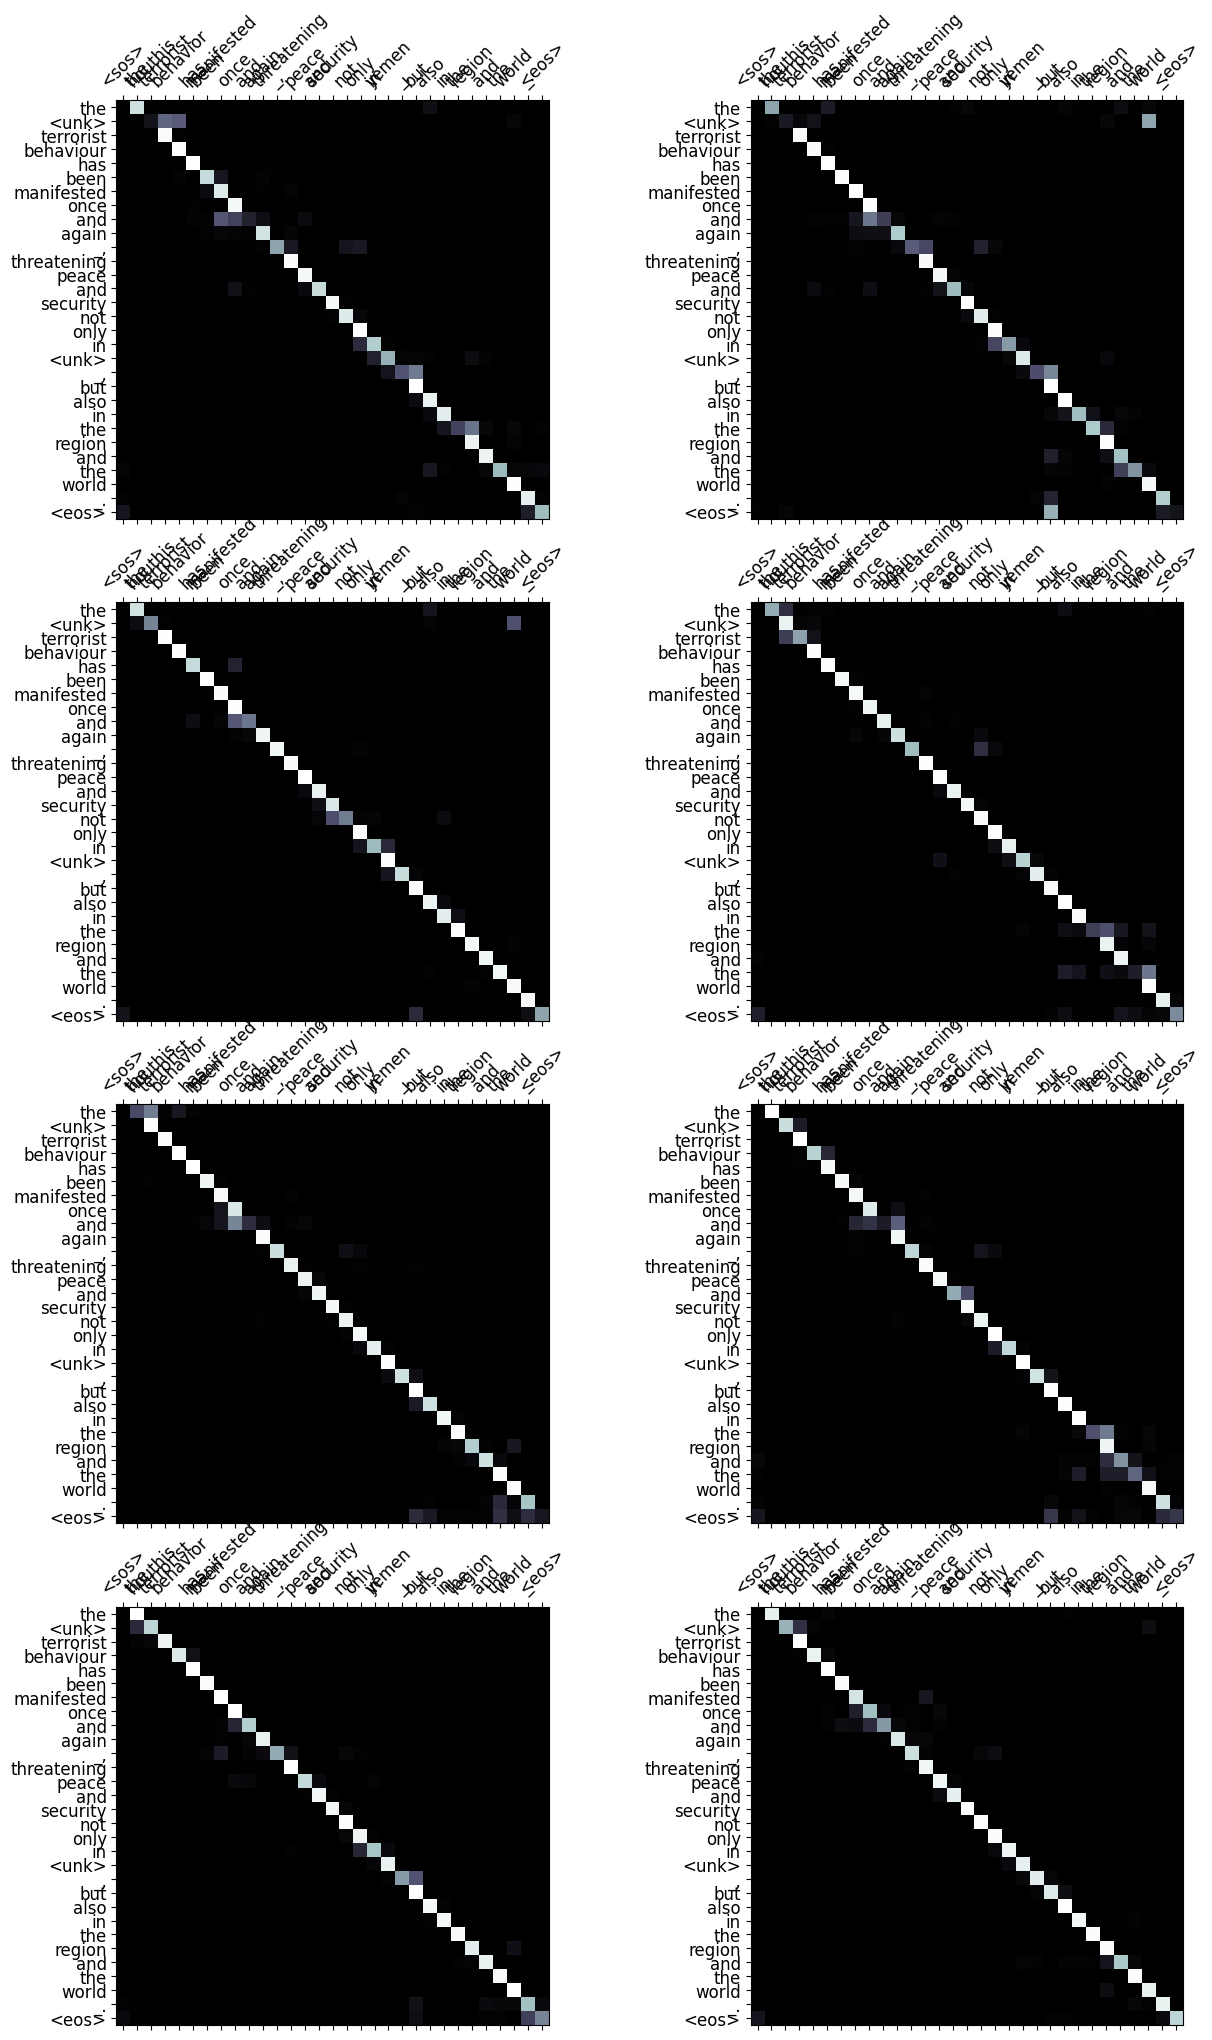

In [ ]:
display_attention(src, translation, attention)

###BLEU

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):

    trgs = []
    pred_trgs = []

    for datum in data:

        src = vars(datum)['src']
        trg = vars(datum)['trg']

        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)

        #cut off <eos> token
        pred_trg = pred_trg[:-1]

        pred_trgs.append(pred_trg)
        trgs.append([trg])

    return bleu_score(pred_trgs, trgs)

In [ ]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 56.27


##BLEU baseline - same src trg

In [ ]:
from torchtext.data.metrics import bleu_score

# item=test_data[0]#["src"]
# vars(item)['src']
trgs = []
pred_trgs = []
for datum in test_data[:1000]:
    src = vars(datum)['src']
    trg = vars(datum)['trg']
    #pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
    pred_trgs.append(src)
    trgs.append([trg])
bleu_score=bleu_score(pred_trgs, trgs)
print(f'BLEU score (Same SRC/TRG) = {bleu_score*100:.2f}')


BLEU score (Same SRC/TRG) = 94.58


In [ ]:
len(train_data)

61510

###Apply model to testset
visualize output as html table

In [ ]:
from code_utils.web_lib import *
model_fname='tut2-model.pt'
#model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

model.load_state_dict(torch.load(model_fname,map_location=device)) #map_location=torch.device('cpu')


example_idx = 12
pair_list_no_edits=[]
pair_list_with_edits=[]
for item0 in test_data.examples:
  src0=item0.src
  trg0=item0.trg
  if src0!=trg0: pair_list_with_edits.append((src0,trg0))
  else: pair_list_no_edits.append((src0,trg0))
  if len(pair_list_with_edits)>50: break

data_list1=[]
for src0,trg0 in pair_list_with_edits+pair_list_no_edits:
  print(src0)
  print(trg0)
  translation, attention = translate_sentence(src0, SRC, TRG, model, device)
  print(translation)
  src_html0=de_tok2str(src0)
  human_edit_html=get_edit_html(src0,trg0)
  mt_edit_html=get_edit_html(src0,translation)
  data_list1.append((src_html0,human_edit_html,mt_edit_html))
  # print(human_edit_html)
  # print(mt_edit_html)
  print("------")




# all_paras,paras_dict=docx_obj.extract_paras()

# for para_path0,para_content0 in all_paras:
#   #print(para_content0)
#   orig0,final0,edit0=get_edit_info(para_content0)
#   if orig0==final0=="": continue
#   print("para_path0",para_path0)
#   print("orig0",orig0)
#   print("final0",final0)
#   print("edit0",edit0)
#   print("-----")
#   data_list1.append((orig0,final0,edit0))



table_content0=""
for i0,tag_item0 in enumerate(data_list1):
  original0,final0,edited0=tag_item0
  table_class="table-light"
  if i0%2!=0: table_class="table-dark text-dark"
  cur_tr0='<tr class="%s"><td>%s</td><td>%s</td><td>%s</td></tr>'%(table_class,original0,final0,edited0)
  table_content0+=cur_tr0

template_fpath="templates/editing-mt-template.html"
template_fopen=open(template_fpath)
template_content=template_fopen.read()
template_fopen.close()
template_dom_obj=DOM(template_content)
repl_dict={"#data_display_table_body":table_content0}
out_html=template_dom_obj.replace(repl_dict)

out_fopen=open("output/mt_pre-edit-initial1.html","w")
out_fopen.write(out_html)
out_fopen.close()

# src = vars(test_data.examples[example_idx])['src']
# trg = vars(test_data.examples[example_idx])['trg']

# print(f'src = {src}')
# print(f'trg = {trg}')

# translation, attention = translate_sentence(src, SRC, TRG, model, device)

# print(f'predicted trg = {translation}')


['On', '5', 'October', '2022', '_,', 'the', 'terrorist', 'Houthis', 'militias', 'sent', 'a', 'letter', 'to', 'a', 'UN', 'member', 'state', 'with', 'threats', 'to', 'target', 'the', 'crew', 'and', 'the', 'tanker', 'raising', 'its', 'flag', 'if', 'it', 'approaches', 'Yemeni', 'ports', 'and', 'territorial', 'water', '_.']
['On', '5', 'October', '2022', '_,', 'the', 'terrorist', 'Houthi', 'militias', 'sent', 'a', 'letter', 'to', 'a', 'State', 'Member', 'of', 'the', 'United', 'Nations', 'with', 'threats', 'to', 'target', 'the', 'crew', 'and', 'the', 'tanker', 'flying', 'its', 'flag', 'if', 'the', 'tanker', 'approached', 'Yemeni', 'ports', 'and', 'territorial', 'waters', '_.']
['on', '5', '<unk>', '2022', '_,', 'the', 'terrorist', '<unk>', 'militias', 'sent', 'a', 'letter', 'to', 'a', 'member', 'state', 'with', 'threats', 'to', 'target', 'the', 'crew', 'and', 'the', 'tanker', 'flying', 'its', 'flag', 'if', 'the', 'tanker', 'approached', '<unk>', 'ports', 'and', 'territorial', 'waters', '_.',

In [ ]:
from difflib import SequenceMatcher
seq1=[1,2,2,4,5,5,7]
seq2=[1,2,3,4,5,6,7,8]
match_obj=SequenceMatcher(None,seq1,seq2)

In [ ]:
for a in match_obj.get_grouped_opcodes():
  print(a)

[('equal', 0, 2, 0, 2), ('replace', 2, 3, 2, 3), ('equal', 3, 5, 3, 5), ('replace', 5, 6, 5, 6), ('equal', 6, 7, 6, 7), ('insert', 7, 7, 7, 8)]


In [ ]:
for a in match_obj.matching_blocks:
  print(a)

Match(a=0, b=0, size=2)
Match(a=3, b=3, size=2)
Match(a=6, b=6, size=1)
Match(a=7, b=8, size=0)


In [ ]:
for a in match_obj.get_matching_blocks():
  print(a)

Match(a=0, b=0, size=2)
Match(a=3, b=3, size=2)
Match(a=6, b=6, size=1)
Match(a=7, b=8, size=0)


In [ ]:
seq1=[1,2,2,4,5,5,7,9,5]
seq2=[1,2,3,4,5,6,7]
match_obj=SequenceMatcher(None,seq1,seq2)
for a in match_obj.get_opcodes():
  print(a)

('equal', 0, 2, 0, 2)
('replace', 2, 3, 2, 3)
('equal', 3, 5, 3, 5)
('replace', 5, 6, 5, 6)
('equal', 6, 7, 6, 7)
('delete', 7, 9, 7, 7)


In [ ]:
from code_utils.general import *
src = ['The', 'Government', 'of', 'Yemen', 'is', 'calling', 'on', 'the', 'Security', 'Council', 'to', 'shoulder', 'its', 'responsibility', 'and', 'take', 'firm', 'actions', 'to', 'end', 'the', 'Houthis', 'terrorist', 'behavior', 'before', 'the', 'terrorist', 'Houthis', 'act', 'upon', 'their', 'threats', 'once', 'again', '_.']
trg = ['The', 'Government', 'of', 'Yemen', 'is', 'calling', 'upon', 'the', 'Security', 'Council', 'to', 'shoulder', 'its', 'responsibility', 'and', 'take', 'firm', 'actions', 'to', 'end', 'the', 'Houthis', "_'", 'terrorist', 'behaviour', 'before', 'the', 'terrorist', 'Houthis', 'act', 'upon', 'their', 'threats', 'once', 'again', '_.']
predicted_trg = ['the', 'government', 'of', '<unk>', 'is', 'calling', 'on', 'the', 'security', 'council', 'to', 'shoulder', 'its', 'responsibility', 'and', 'take', 'firm', 'actions', 'to', 'end', 'the', '<unk>', 'terrorist', 'behaviour', 'before', 'the', 'terrorist', '<unk>', 'act', 'upon', 'their', 'threats', 'once', 'again', '_.', '<eos>']
predicted_trg=[v for v in predicted_trg if v!="<eos>"]
def get_seq_edits(tokens1,tokens2):
  match_obj=SequenceMatcher(None,tokens1,tokens2)
  final_list=[]
  for a in match_obj.get_opcodes():
    match_type,x0,x1,y0,y1=a
    if match_type=="delete":
      #print("deleted",tokens1[x0:x1])
      final_list.append(("deleted",tokens1[x0:x1]))
    if match_type=="equal":
      #print("equal",tokens1[x0:x1])
      final_list.append(("equal",tokens1[x0:x1]))
    if match_type=="replace":
      final_list.append(("delete",tokens1[x0:x1]))
      final_list.append(("insert",tokens2[y0:y1]))
    if match_type=="insert":
      final_list.append(("insert",tokens2[y0:y1]))
  return final_list

def make_html_safe(text):
  text=text.replace(">","&gt;").replace("<","&lt;")
  return text

def get_edit_html(tokens1,tokens2):
  edit_list=get_seq_edits(tokens1,tokens2)
  final_str_items=[]
  for edit_type0,chunk0 in edit_list:
    cur_chunk_str=de_tok2str(chunk0)
    cur_chunk_str=make_html_safe(cur_chunk_str)
    if edit_type0=="delete": final_str_items.append('<del>%s</del>'%cur_chunk_str)
    elif edit_type0=="insert": final_str_items.append('<ins>%s</ins>'%cur_chunk_str)
    else: final_str_items.append(cur_chunk_str)
  final_str=" ".join(final_str_items)
  return final_str
    #print(edit_type0,)


    #print(a)

list1=get_seq_edits(src,predicted_trg)
# for a in list1:
#   print(a)

out=get_edit_html(src,predicted_trg)
print(out)
# for a in match_obj.get_grouped_opcodes():
#   print(a)

<del>The Government</del> <ins>the government</ins> of <del>Yemen</del> <ins>&lt;unk&gt;</ins> is calling on the <del>Security Council</del> <ins>security council</ins> to shoulder its responsibility and take firm actions to end the <del>Houthis</del> <ins>&lt;unk&gt;</ins> terrorist <del>behavior</del> <ins>behaviour</ins> before the terrorist <del>Houthis</del> <ins>&lt;unk&gt;</ins> act upon their threats once again.


In [ ]:
example_idx = 12

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')


src = ['General', 'Assembly']
trg = ['General', 'Assembly']
predicted trg = ['general', 'assembly', '<eos>']


In [ ]:
test_data.examples[example_idx].

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-47-12d80dc069bb>", line 1, in <cell line: 1>
    test_data.examples[example_idx].edit
AttributeError: 'Example' object has no attribute 'edit'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/pyt

###Optimized BLEU

In [ ]:
def translate_sentence_vectorized(src_tensor, src_field, trg_field, model, device, max_len=50):
    assert isinstance(src_tensor, torch.Tensor)

    model.eval()
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
    # enc_src = [batch_sz, src_len, hid_dim]

    trg_indexes = [[trg_field.vocab.stoi[trg_field.init_token]] for _ in range(len(src_tensor))]
    # Even though some examples might have been completed by producing a <eos> token
    # we still need to feed them through the model because other are not yet finished
    # and all examples act as a batch. Once every single sentence prediction encounters
    # <eos> token, then we can stop predicting.
    translations_done = [0] * len(src_tensor)
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        pred_tokens = output.argmax(2)[:,-1]
        for i, pred_token_i in enumerate(pred_tokens):
            trg_indexes[i].append(pred_token_i)
            if pred_token_i == trg_field.vocab.stoi[trg_field.eos_token]:
                translations_done[i] = 1
        if all(translations_done):
            break

    # Iterate through each predicted example one by one;
    # Cut-off the portion including the after the <eos> token
    pred_sentences = []
    for trg_sentence in trg_indexes:
        pred_sentence = []
        for i in range(1, len(trg_sentence)):
            if trg_sentence[i] == trg_field.vocab.stoi[trg_field.eos_token]:
                break
            pred_sentence.append(trg_field.vocab.itos[trg_sentence[i]])
        pred_sentences.append(pred_sentence)

    return pred_sentences, attention

from torchtext.data.metrics import bleu_score

def calculate_bleu_alt(iterator, src_field, trg_field, model, device, max_len = 50):
    trgs = []
    pred_trgs = []
    with torch.no_grad():
        for batch in iterator:
            src = batch.src
            trg = batch.trg
            _trgs = []
            for sentence in trg:
                tmp = []
                # Start from the first token which skips the <start> token
                for i in sentence[1:]:
                    # Targets are padded. So stop appending as soon as a padding or eos token is encountered
                    if i == trg_field.vocab.stoi[trg_field.eos_token] or i == trg_field.vocab.stoi[trg_field.pad_token]:
                        break
                    tmp.append(trg_field.vocab.itos[i])
                _trgs.append([tmp])
            trgs += _trgs
            pred_trg, _ = translate_sentence_vectorized(src, src_field, trg_field, model, device)
            pred_trgs += pred_trg
    return pred_trgs, trgs, bleu_score(pred_trgs, trgs)



In [ ]:
#calculate_bleu_alt(test_iterator)
#calculate_bleu(test_data, SRC, TRG, model, device)
pred_trgs0, trgs0,bleu_score2 = calculate_bleu_alt(test_data, SRC, TRG, model, device)
print("bleu_score2",bleu_score2)

TypeError: ignored

In [ ]:
bleu_score2

([['<unk>'],
  ['3'],
  ['<unk>'],
  ['<unk>'],
  ['<unk>'],
  ['045720000'],
  ['<unk>'],
  ['<unk>'],
  ['266954030480000'],
  ['<unk>'],
  ['<unk>'],
  ['<unk>'],
  ['E/2023/47'],
  ['S/2011/818'],
  ['266954030480000'],
  ['S/2011/818'],
  ['S/2011/818'],
  ['S/2011/818'],
  ['266954030480000'],
  ['S/2011/818'],
  ['<unk>'],
  ['<unk>'],
  ['<unk>'],
  ['<unk>'],
  ['two'],
  ['<unk>'],
  ['<unk>'],
  ['2604'],
  ['<unk>'],
  ['<unk>'],
  ['<unk>'],
  ['<unk>'],
  ['2669540304800'],
  ['2022'],
  ['CEDAW/C/CUB/9'],
  ['market'],
  ['<unk>'],
  ['<unk>'],
  ['Organization'],
  ['–'],
  ['235'],
  ['2606'],
  ['<unk>'],
  ['<unk>'],
  ['<unk>'],
  ['<unk>'],
  ['<unk>'],
  ['<unk>'],
  ['358'],
  ['791'],
  ['<unk>'],
  ['Sven'],
  ['2021'],
  ['94'],
  ['Xue'],
  ['<unk>'],
  ['137'],
  ['<unk>'],
  ['799'],
  ['итого'],
  ['<unk>'],
  ['N.Занятость'],
  ['<unk>'],
  ['IV.Exemptions'],
  ['II.Background'],
  ['E/CN.3/2023/26'],
  ['Total'],
  ['14'],
  ['14'],
  ['<unk>'],
  ['CEDA

In [ ]:
import torchtext
from code_utils.general import *

SRC = Field(tokenize = tok,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

TRG = Field(tokenize = tok,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

dataset0=torchtext.data.TabularDataset("test_bitext.tsv", "tsv", fields = (SRC, TRG), skip_header=True, csv_reader_params={})


TypeError: ignored

In [ ]:
#https://stackoverflow.com/questions/53046583/how-to-create-a-torchtext-data-tabulardataset-directly-from-a-list-or-dict
import torchtext
class TabularDataset_From_List(torchtext.data.Dataset):

    def __init__(self, input_list, format, fields, skip_header=False, **kwargs):
        make_example = {
            'json': Example.fromJSON, 'dict': Example.fromdict,
            'tsv': Example.fromTSV, 'csv': Example.fromCSV}[format.lower()]

        examples = [make_example(item, fields) for item in input_list]

        if make_example in (Example.fromdict, Example.fromJSON):
            fields, field_dict = [], fields
            for field in field_dict.values():
                if isinstance(field, list):
                    fields.extend(field)
                else:
                    fields.append(field)

        super(TabularDataset_From_List, self).__init__(examples, fields, **kwargs)

    @classmethod
    def splits(cls, path=None, root='.data', train=None, validation=None,
               test=None, **kwargs):
        if path is None:
            path = cls.download(root)
        train_data = None if train is None else cls(
            train, **kwargs)
        val_data = None if validation is None else cls(
            validation, **kwargs)
        test_data = None if test is None else cls(
            test, **kwargs)
        return tuple(d for d in (train_data, val_data, test_data)
                     if d is not None)

obj0=TabularDataset_From_List()

In [ ]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
     batch_size = BATCH_SIZE,
     device = device)

AttributeError: ignored

In [ ]:
#https://github.com/jadore801120/attention-is-all-you-need-pytorch
!rm -rf attention_mt
#!git clone https://github.com/jadore801120/attention-is-all-you-need-pytorch attention_mt
!git clone https://github.com/hmghaly/attention-is-all-you-need-pytorch.git attention_mt


Cloning into 'attention_mt'...
remote: Enumerating objects: 753, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 753 (delta 2), reused 0 (delta 0), pack-reused 747
Receiving objects: 100% (753/753), 170.15 KiB | 1.62 MiB/s, done.
Resolving deltas: 100% (493/493), done.


In [ ]:
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

2023-06-07 19:36:15.512036: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-07 19:36:16.612112: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 72.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
2023-06-07 19:36:28.984037: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the

In [ ]:
!pip install dill
!pip install torchtext==0.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.1 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.4.0
    Uninstalling torchtext-0.4.0:
      Successfully uninstalled torchtext-0.4.0


###Test on custom tabular data

In [ ]:
from torchtext.data import Field, BucketIterator
import torchtext

SRC = Field()
TRG = Field()
fields = {'src': ('src', SRC), 'trg': ('trg', TRG)}
train_data, test_data = torchtext.data.TabularDataset.splits(
                            path = 'test_files',
                            train = 'src_trg_train.json',
                            test = 'src_trg_train.json',
                            format = 'json',
                            fields = fields
)



In [ ]:
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator


NAME = Field()
SAYING = Field()
PLACE = Field()

In [ ]:
import torchtext
fields = {'name': ('n', NAME), 'location': ('p', PLACE), 'quote': ('s', SAYING)}
train_data, test_data = torchtext.data.TabularDataset.splits(
                            path = 'test_files',
                            train = 'train.json',
                            test = 'train.json',
                            format = 'json',
                            fields = fields
)

In [ ]:
a=train_data.examples[0]
a.n

['John']

In [ ]:
a=train_data.examples[0]
a.src

['an', 'english', 'sentence']

In [ ]:
os.chdir("attention_mt")
!python preprocess.py -lang_src de -lang_trg en -share_vocab -save_data m30k_deen_shr.pkl
os.chdir(cwd)

2023-06-07 19:36:53.277800: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-07 19:36:54.385958: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Namespace(lang_src='de', lang_trg='en', save_data='m30k_deen_shr.pkl', data_src=None, data_trg=None, max_len=100, min_word_count=3, keep_case=False, share_vocab=True)
Traceback (most recent call last):
  File "/content/drive/MyDrive/AI_UN/attention_mt/preprocess.py", line 336, in <module>
    main_wo_bpe()
  File "/content/drive/MyDrive/AI_UN/attention_mt/preprocess.py", line 271, in main_wo_bpe
    src_lang_model = spacy.load(spacy_src_lang_model_path)
  File "/usr/local/lib/python3.10/dist-packages/spacy/__init__.py", line 54, in load
    return util.load_

In [ ]:
import spacy
spacy.load('de_core_news_sm')

In [ ]:
spacy.load('en_core_web_sm')

In [ ]:
!!pip install torchtext==0.4

['Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/',
 'Requirement already satisfied: torchtext==0.4 in /usr/local/lib/python3.10/dist-packages (0.4.0)',
 'Requirement already satisfied: tqdm in /usr/local/lib/python3.10/dist-packages (from torchtext==0.4) (4.65.0)',
 'Requirement already satisfied: requests in /usr/local/lib/python3.10/dist-packages (from torchtext==0.4) (2.27.1)',
 'Requirement already satisfied: torch in /usr/local/lib/python3.10/dist-packages (from torchtext==0.4) (2.0.1+cu118)',
 'Requirement already satisfied: numpy in /usr/local/lib/python3.10/dist-packages (from torchtext==0.4) (1.22.4)',
 'Requirement already satisfied: six in /usr/local/lib/python3.10/dist-packages (from torchtext==0.4) (1.16.0)',
 'Requirement already satisfied: urllib3<1.27,>=1.21.1 in /usr/local/lib/python3.10/dist-packages (from requests->torchtext==0.4) (1.26.15)',
 'Requirement already satisfied: certifi>=2017.4.17 in /usr/local/lib/pyth

In [ ]:
!pip install -U torchtext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torchtext.data

In [ ]:
import torchtext.datasets as datasets

In [ ]:
datasets.

In [ ]:
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

ModuleNotFoundError: ignored

# ★ Build replacement model

In [ ]:
for set_name0 in ["train","test","validation"]:
  set_path=os.path.join("output","%s_set.json"%set_name0)
  print(set_path)


output/train_set.json
output/test_set.json
output/validation_set.json


In [ ]:
from code_utils.cat_utils import *
from itertools import groupby

def get_first_dict(list_of_tokenized): #group a list of tokenized strings by the first token, use this first token to retrieve all strings starting with it
  list_of_tokenized.sort()
  grouped=[(key,list(group)) for key,group in groupby(list_of_tokenized,lambda x:x[0])]
  return dict(iter(grouped))


fpath='output/train_set.json'
fopen=open(fpath)
repl_count_dict={}
for i0,line0 in enumerate(fopen):
  line_dict=json.loads(line0.strip())
  src_tokens=tok(line_dict["src"])
  trg_tokens=tok(line_dict["trg"])
  seq_edit_list=get_seq_replace(src_tokens,trg_tokens)
  repl_items=[]
  for a in seq_edit_list:
    if a[0]!="replace": continue
    repl_items.append(a)
  if repl_items:
    for rp in repl_items:
      repl_src,repl_trg=rp[1],rp[2]
      repl_key=(" ".join(repl_src)," ".join(repl_trg))
      repl_count_dict[repl_key]=repl_count_dict.get(repl_key,0)+1

#now creating first token dict for easy retrieval
keys_with_first=[]
for key0,val0 in repl_count_dict.items():
  src0,trg0 = key0
  src_first0=src0.split(" ")[0]
  keys_with_first.append((src_first0,key0))

keys_with_first.sort()
grouped=[(key,[v[1] for v in list(group)]) for key,group in groupby(keys_with_first,lambda x:x[0])]
first_dict=dict(iter(grouped))

# key_dict_pos={}
# key_dict_neg={}
valid_repl_dict={}
fopen.seek(0)
for i0,line0 in enumerate(fopen):
  if i0%1000==0: print("checking valid replacements:", i0)
  line_dict=json.loads(line0.strip())
  src_tokens=tok(line_dict["src"])
  trg_tokens=tok(line_dict["trg"])
  for s_tok0 in list(set(src_tokens)):
    corr_keys=first_dict.get(s_tok0,[])
    if corr_keys==[]: continue #print(s_tok0,corr_keys)
    for corr0 in corr_keys:
      corr_src0,corr_trg0=corr0
      corr_src_toks0=corr_src0.split(" ")
      if not general.is_in(corr_src_toks0,src_tokens): continue
      valid=True
      if general.is_in(corr_src_toks0,trg_tokens): valid=False #if the src part of the repl key exists in the target side, it is not valid

      corr_trg_toks0=corr_trg0.split(" ")
      if not general.is_in(corr_trg_toks0,trg_tokens): valid=False #if the trg part of the replacement does not exist in the target part, it is not valid
      temp_dict=valid_repl_dict.get(corr0,{})
      temp_dict[valid]=temp_dict.get(valid,0)+1
      valid_repl_dict[corr0]=temp_dict

      #print(s_tok0,corr0)

  #if i0>100: break

# for a,b in valid_repl_dict.items():
#   print(a,b)
#out_data=json.load(fopen)


# items=list(repl_count_dict.items())
# items.sort(key=lambda x:x[-1])

# tmp_src_list=[]
# tmp_trg_list=[]
# for key0,count0 in items:
#   repl_src0,repl_trg0=key0
#   tmp_src_list.append(repl_src0)
#   tmp_trg_list.append(repl_trg0)
#   #print(key0,count0)
# tmp_src_list=list(set(tmp_src_list))
# tmp_trg_list=list(set(tmp_trg_list))

# tmp_src_tok_list=[v.split(" ") for v in tmp_src_list]
# tmp_trg_tok_list=[v.split(" ") for v in tmp_trg_list]

# repl_first_src_dict=get_first_dict(tmp_src_tok_list)
# repl_first_trg_dict=get_first_dict(tmp_trg_tok_list)

# print("tmp_src_list",len(tmp_src_list))
# print("tmp_trg_list",len(tmp_trg_list))

# fopen.seek(0)

# phrase_src_count_dict={} #how many times did a phrase occur in src (before editing)
# phrase_trg_count_dict={} #how many times did a phrase occur in trg (after editing)

# for i0,line0 in enumerate(fopen):
#   if i0%5000==0: print(i0)
#   line_dict=json.loads(line0.strip())
#   src_tokens=tok(line_dict["src"])
#   trg_tokens=tok(line_dict["trg"])
#   for t_tok0 in list(set(trg_tokens)):
#     corr_src_phrases=repl_first_src_dict.get(t_tok0,[]) #check if the src word/phrase that is to be replaced - also exists in target (e.g. honor)
#     for src_phrase0 in corr_src_phrases:
#       cur_src_phrase_locs=general.is_in(src_phrase0,trg_tokens)
#       if len(cur_src_phrase_locs)>0:
#         phrase_str=" ".join(src_phrase0)
#         phrase_src_count_dict[phrase_str]=phrase_src_count_dict.get(phrase_str,0)+len(cur_src_phrase_locs)


fopen.close()

checking valid replacements: 0
checking valid replacements: 1000
checking valid replacements: 2000
checking valid replacements: 3000
checking valid replacements: 4000
checking valid replacements: 5000
checking valid replacements: 6000
checking valid replacements: 7000
checking valid replacements: 8000
checking valid replacements: 9000
checking valid replacements: 10000
checking valid replacements: 11000
checking valid replacements: 12000
checking valid replacements: 13000
checking valid replacements: 14000
checking valid replacements: 15000
checking valid replacements: 16000
checking valid replacements: 17000
checking valid replacements: 18000
checking valid replacements: 19000
checking valid replacements: 20000
checking valid replacements: 21000
checking valid replacements: 22000
checking valid replacements: 23000
checking valid replacements: 24000
checking valid replacements: 25000
checking valid replacements: 26000
checking valid replacements: 27000
checking valid replacements: 2800

In [ ]:
import json
items=list(repl_count_dict.items())
items.sort(key=lambda x:-x[-1])
validated_repl_list=[]
for repl_key0,repl_count0 in items:
  temp_valid_dict=valid_repl_dict.get(repl_key0,{})
  true_count=temp_valid_dict.get(True,0)
  false_count=temp_valid_dict.get(False,0)
  sum_vals=sum(temp_valid_dict.values())
  true_ratio=0
  if sum_vals!=0: true_ratio=true_count/sum_vals
  #print(repl_key0,repl_count0,temp_valid_dict, round(true_ratio,2))
  validated_repl_list.append((repl_key0,true_count,false_count,repl_count0,true_ratio))

validated_repl_list.sort(key=lambda x:(-x[-1],-x[-2]))
validated_fopen=open("repl_validated.txt","w")
validated_table_fopen=open("repl_validated_table.tsv","w")
for a in validated_repl_list:
  repl_key0,true_count,false_count,repl_count0,true_ratio=a
  repl_src0,repl_trg0=repl_key0
  temp_dict={}
  temp_dict["src"]=repl_src0
  temp_dict["trg"]=repl_trg0
  temp_dict["repl_count"]=repl_count0
  temp_dict["true_count"]=true_count
  temp_dict["false_count"]=false_count
  temp_dict["true_ratio"]=true_ratio
  row_items=[repl_src0,repl_trg0,true_count,false_count,repl_count0,true_ratio]
  row_items_str="\t".join([str(v) for v in row_items])
  validated_table_fopen.write(row_items_str+"\n")



  validated_fopen.write(json.dumps(temp_dict)+"\n")



  #print(a)
validated_fopen.close()
validated_table_fopen.close()
print(f"finished processing {len(validated_repl_list)} items")

finished processing 7008 items


##test replacement with validated replacement data

In [ ]:
import json, math
from itertools import groupby
from code_utils import general

def apply_replace(sent_tokens,first_repl_dict):
  new_sent_tokens=list(sent_tokens)
  valid_replacements=[]
  for word0 in list(set(sent_tokens)):
    all_corr=first_repl_dict.get(word0,[])
    for corr0 in all_corr:
      if not general.is_in(corr0[0],sent_tokens): continue
      valid_replacements.append(corr0)
  for repl0 in valid_replacements:
    repl_src,repl_trg,repl_wt=repl0
    new_sent_tokens=repl_phrase(new_sent_tokens,repl_src,repl_trg)
  return new_sent_tokens



def repl_phrase(sent_tokens,phrase_to_be_replaced,new_phrase): #replace a
  last_i=0
  new_tokens=[]
  found_spans=general.is_in(phrase_to_be_replaced,sent_tokens)
  for span0 in found_spans:
    span_i0,span_j0=span0
    new_tokens.extend(sent_tokens[last_i:span_i0])
    new_tokens.extend(new_phrase)
    last_i=span_j0+1
  new_tokens.extend(sent_tokens[last_i:])
  return new_tokens







validated_fopen=open("repl_validated.txt")
#repl_model_first_dict={}
first_repl_wt_list=[]
for line_i,line0 in enumerate(validated_fopen):
  line_dict=json.loads(line0)
  src0=line_dict.get("src","")
  trg0=line_dict.get("trg","")
  first=src0.split(" ")[0]
  true_ratio=line_dict.get("true_ratio",0)
  repl_count=line_dict.get("repl_count",0)

  if repl_count<1 or true_ratio<0.7: continue

  wt0=true_ratio*math.log(repl_count)
  first_repl_wt_list.append((first,(src0.split(" "),trg0.split(" "),wt0)))

first_repl_wt_list.sort(key=lambda x:x[0])
first_repl_wt_list_grouped=[(key,[v[1] for v in list(group)]) for key,group in groupby(first_repl_wt_list,lambda x:x[0])]
repl_model_first_dict=dict(iter(first_repl_wt_list_grouped))

# items=list(repl_model_first_dict.items())
# for a,b in items[200:400]:
#   print(a,b)
validated_fopen.close()


#test_data
sent="the advisor for AP and APC issues, also RCOs with roundtables and a roadmap and have the honor to have learnt"
sent_tokens=sent.split()

out0=apply_replace(sent_tokens,repl_model_first_dict)
print(out0)

['the', 'advisor', 'for', 'armour', '_-_', 'piercing', 'and', 'armoured', 'personnel', 'carrier', 'issues,', 'also', 'RCOs', 'with', 'round', 'tables', 'and', 'a', 'roadmap', 'and', 'have', 'the', 'honour', 'to', 'have', 'learnt']


##Apply BLEU score to replacement model

In [ ]:
from code_utils.general import *
from torchtext.data.metrics import bleu_score
import time

# item=test_data[0]#["src"]
# vars(item)['src']
analysis_dir="analysis"
if not os.path.exists(analysis_dir): os.makedirs(analysis_dir)

analysis_fname="replacement_performance.tsv"
analysis_fpath=os.path.join(analysis_dir,analysis_fname)
fopen=open(analysis_fpath,"w")
t0=time.time()
trgs = []
pred_trgs = []
for i0,datum in enumerate(test_data):
  if i0%1000==0: print(i0, "out of", len(test_data))
  src = vars(datum)['src']
  trg = vars(datum)['trg']
  src_sent=de_tok2str(src)
  correct_trg_sent=de_tok2str(trg)
  repl_outcome_tokens=apply_replace(src,repl_model_first_dict)
  repl_outcome_str=de_tok2str(repl_outcome_tokens)

  pred_trg=repl_outcome_tokens

  # doc0 = nlp(src_sent)
  # doc0._.performed_spellCheck
  # spell_check_outcome=doc0._.outcome_spellCheck
  # pred_trg=tok(spell_check_outcome)
  #pred_trg=src

  line="%s\t%s\t%s"%(src_sent,correct_trg_sent,repl_outcome_str)
  line.replace("\n","<br>")
  fopen.write(line+"\n")
  pred_trgs.append(pred_trg)
  trgs.append([trg])
t1=time.time()
bleu_score=bleu_score(pred_trgs, trgs)
t2=time.time()
elapsed_processing=round(t1-t0,2)
elapsed_bleu=round(t2-t1,2)

print(f'BLEU score (Replacement Model) = {bleu_score*100:.2f}')
print("elapsed_processing",elapsed_processing)
print("elapsed_bleu",elapsed_bleu)

#BLEU score (Replacement Model) = 92.41 | if repl_count<1 or true_ratio<0.7: continue
#BLEU score (Replacement Model) = 92.40 | if repl_count<2 or true_ratio<0.7: continue
#BLEU score (Replacement Model) = 92.39 | if repl_count<2 or true_ratio<0.6: continue
#BLEU score (Replacement Model) = 92.37 | if repl_count<2 or true_ratio<0.75: continue
#BLEU score (Replacement Model) = 92.33 | if repl_count<2 or true_ratio<0.5: continue
#BLEU score (Replacement Model) = 92.33 | if repl_count<3 or true_ratio<0.6: continue
#BLEU score (Replacement Model) = 92.29 | if repl_count<3 or true_ratio<0.5: continue
#BLEU score (Replacement Model) - No filters = 21.40

0 out of 18421
1000 out of 18421
2000 out of 18421
3000 out of 18421
4000 out of 18421
5000 out of 18421
6000 out of 18421
7000 out of 18421
8000 out of 18421
9000 out of 18421
10000 out of 18421
11000 out of 18421
12000 out of 18421
13000 out of 18421
14000 out of 18421
15000 out of 18421
16000 out of 18421
17000 out of 18421
18000 out of 18421
BLEU score (Replacement Model) = 92.41
elapsed_processing 16.02
elapsed_bleu 13.62


In [ ]:
keys_with_first=[]
for key0,val0 in repl_count_dict.items():
  src0,trg0 = key0
  src_first0=src0.split(" ")[0]
  keys_with_first.append((src_first0,key0))

keys_with_first.sort()
grouped=[(key,[v[1] for v in list(group)]) for key,group in groupby(keys_with_first,lambda x:x[0])]
first_dict=dict(iter(grouped))
grouped_dict_items=list(first_dict.items())

for a in grouped_dict_items[:500]:
  print(a)

('"', [('" Factsheet', '“_ Indigenous women with disabilities _” (_ 2020 _)_ _, fact sheet')])
('"_', [('"_', '“_')])
('#', [('#', 'number')])
('$', [('$ 1,158,506,500', '$1,158,506,500')])
('$14,600', [('$14,600', '$28,400')])
('$3389', [('$3389', '$3,389')])
('%', [('%', 'Percentage'), ('%', 'per cent'), ('% in 2020 _-_ 2021', 'per cent during the period 2020–2021')])
('&', [('&', 'and'), ('&', 'and Kenneth'), ('&', 'and Ram'), ('& Development', 'and development'), ('& Fort _, T _.', 'and Teresa')])
("'_", [("'_", '“_')])
('(', [('( HYPERLINK "_ https://daccess-ods.un.org/tmp/1377058.17818642.html', '(_'), ('( HYPERLINK "_ https://undocs.org/en/S/2021/807', '(_')])
('(_', [('(_', '_,'), ('(_', '_, including the'), ('(_', '_, namely _,'), ('(_', '_”_ _,'), ('(_', 'coalition _, which'), ('(_', 'from'), ('(_', 'the global South'), ('(_ 1991 _)_ _, General', 'general'), ('(_ 2009 _)_', 'Journal of International Business Studies _, vol'), ('(_ 2019 _-_ 2025 _)_', '2019–2025'), ('(_ 2023 _

In [ ]:
items=list(repl_count_dict.items())
items.sort(key=lambda x:-x[-1])
for a in items[:100]:
  print(a)

(('UN', 'United Nations'), 142)
(('_,', 'and'), 93)
(('-', '–'), 88)
(('Annex', 'annex'), 82)
(('_.', '_;'), 63)
(('—', '–'), 62)
(('this', 'that'), 55)
(('this', 'the present'), 53)
(('Chapter', 'chapter'), 47)
(('_,', '_;'), 45)
(('_%', 'per cent'), 44)
(('is', 'was'), 40)
(('RCs', 'resident coordinators'), 39)
(('‘_', '“_'), 37)
(('_)', '_)_ _.'), 36)
(('2022[KEEP', '2022 [_ _[_ KEEP'), 34)
(('to', 'with'), 33)
(('_)', '_)_ _,'), 30)
(('are', 'were'), 28)
(('Appendix', 'appendix'), 28)
(('P4', 'P _-_ 4'), 28)
(('Article', 'article'), 27)
(('Members', 'members'), 26)
(('the', 'a'), 26)
(('_;', '_,'), 24)
(('_’', '_”'), 24)
(('para', 'paragraph'), 24)
(('&', 'and'), 24)
(('P3', 'P _-_ 3'), 24)
(('_)_ _.', '_)'), 23)
(('Resolution', 'resolution'), 22)
(('SIDS', 'small island developing States'), 22)
(('EDD', 'Division'), 22)
(('has', 'had'), 21)
(('due', 'owing'), 21)
(('percent', 'per cent'), 21)
(('to', 'for'), 21)
(('of', 'for'), 20)
(('as well as', 'and'), 20)
(('Case', 'case'), 20

In [ ]:
output_fpath="edit_training_data_analysis.tsv"
output_fopen=open(output_fpath,"w")
items=list(repl_count_dict.items())
items.sort(key=lambda x:-x[-1])
#items.sort(key=lambda x:x[-1])
header_line="Replace\tReplace With\tReplace Count\tCounter Examples\n"
output_fopen.write(header_line)
for key0,count0 in items:
  r_src0,r_trg0=key0
  #src_phrase0=" ".join(r_src0)
  #trg_phrase0=" ".join(r_trg0)
  #print(r_src0)
  #print(r_trg0)
  found_in_trg=phrase_src_count_dict.get(r_trg0,0)
  #print()
  print(key0,count0,found_in_trg)
  line="%s\t%s\t%s\t%s\n"%(r_src0,r_trg0,count0,found_in_trg)
  output_fopen.write(line)
  #print("-----")
output_fopen.close()

Streaming output truncated to the last 5000 lines.
('Calls', 'calls') 1 48
('Rules', 'rules') 1 107
('2022 _-_ 2026 by the Meetings of High Contracting Parties', '2022–2026') 1 0
('CCW _, in accordance with', 'the Convention and') 1 0
('of the High Contracting Parties related to emerging technologies', 'on Emerging Technologies') 1 0
('lethal autonomous weapons systems (_ LAWS _) on', 'Lethal Autonomous Weapons Systems from') 1 0
('25 _-_ 29 July and adopted', 'to adopt') 1 0
('adopted', 'to adopt') 1 0
('(_ CCW/CONF.VI/8 _)_ _.', '_;') 1 0
('Nuclear', 'nuclear') 1 0
('Tenth', 'tenth') 1 0
('Ninth', 'ninth') 1 0
('its First', 'the first') 1 0
('State', 'the States') 1 0
('_) ,NPT/CONF.2010/50', '_)_ _, NPT/CONF.2010/50') 1 0
('to prevent and combat the illicit proliferation of firearms and ammunition across the Caribbean', '_)_') 1 0
('in developing', 'to develop') 1 79
('Seventh Extraordinary Meeting', 'seventh extraordinary meeting') 1 0
('TAC Inaugural Meeting _; (_ Based on SG Repo

In [ ]:
phrase_src_count_dict["the"]

47854

In [ ]:
line_dict

{'src': 'Distr.: General', 'trg': 'Distr.: General', 'edit': 'Distr.: General'}

#Apply pretrained transformers and libararies

##Happy Transformer

In [ ]:
#Happy transformer: https://huggingface.co/vennify/t5-base-grammar-correction
!pip install happytransformer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 12.6 MB/s eta 0:00:00


In [ ]:
from happytransformer import HappyTextToText, TTSettings

happy_tt = HappyTextToText("T5", "vennify/t5-base-grammar-correction")

args = TTSettings(num_beams=5, min_length=1)

# Add the prefix "grammar: " before each input
result = happy_tt.generate_text("grammar: This sentences has has bads grammar.", args=args)

print(result.text) # This sentence has bad grammar.


This sentence has bad grammar.


In [ ]:
#sent0="grammar: This sentences has has bads grammar."
sent0="What would your do"
#sent0="This Program show many colors"
#sent0="the walking group had some reservations"
#sent0="the workings group had some reservations"
result = happy_tt.generate_text(sent0, args=args)
print(result.text) # This sentence has bad grammar.


What would you do?


In [ ]:
sent0="grammar: This sentences has has bads grammar."
result = happy_tt.generate_text(sent0, args=args)
print(result.text)


This sentence has bad grammar.


In [ ]:
sent0="the walking group had some reservations"
result = happy_tt.generate_text(sent0, args=args)
print(result.text)

The walking group had some reservations, and the walking group had some reservations.


In [ ]:
#sent0="the walking group had some reservations"
#The walking group had some reservations, and the walking group had some reservations.


##GingerIt

In [ ]:
!pip install gingerit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.3 MB/s eta 0:00:00


In [ ]:
from gingerit.gingerit import GingerIt
sent0="grammar: This sentences has has bads grammar."
parser = GingerIt()
parse_out=parser.parse(sent0)
result0=parse_out["result"]
print("Original:",sent0)
print("Result:",result0)

Original: grammar: This sentences has has bads grammar.
Result: Grammar: This sentence has bad grammar.


In [ ]:
sent0 = 'The smelt of fliwers bring back memories.'

In [ ]:
!pip install grammar

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 842.0/842.0 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 50.7 MB/s eta 0:00:00


In [ ]:
!pip install vineyard

##Contextual Spellcheck

In [ ]:
!pip install contextualSpellCheck

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.8 MB/s eta 0:00:00
  Created wheel for editdistance: filename=editdistance-0.6.0-cp310-cp310-linux_x86_64.whl size=235614 sha256=62d2e3c1baf73523644db286e3cee5030c96b6cda0ba7efcfa2a01c28d7ce6df
  Stored in directory: /root/.cache/pip/wheels/d2/c2/60/295c59f8772b195d952c943f53ac4936e4ac59fc47a0030a1a
Successfully built editdistance
  Attempting uninstall: editdistance
    Found existing installation: editdistance 0.6.2
    Uninstalling editdistance-0.6.2:
      Successfully uninstalled editdistance-0.6.2


In [ ]:
import spacy
from spacy.tokenizer import Tokenizer
import contextualSpellCheck

nlp = spacy.load('en_core_web_sm')
#nlp.tokenizer = Tokenizer(nlp.vocab, token_match=re.compile(r'\S+').match)
contextualSpellCheck.add_to_pipe(nlp)
# doc = nlp('Income was $9.4 milion compard to the prior year of $2.7 milion.')

# print(doc._.performed_spellCheck) #Should be True
# print(doc._.outcome_spellCheck) #Income was $9.4 million compared to the prior year of $2.7 million.

In [ ]:
sent='Income were $9.4 milion compard to the priors year bye $2.7 milion which is an big problem.'
doc = nlp(sent)

print(doc._.performed_spellCheck) #Should be True
print(doc._.outcome_spellCheck) #Income was $9.4 million compared to the prior year of $2.7 million.

True
Income were $9.4 million compared to the previous year bye $2.7 million which is an big problem.


In [ ]:
from code_utils.general import *
from torchtext.data.metrics import bleu_score
import time

# item=test_data[0]#["src"]
# vars(item)['src']
analysis_dir="analysis"
if not os.path.exists(analysis_dir): os.makedirs(analysis_dir)
analysis_fname="contextual_performance.tsv"
analysis_fpath=os.path.join(analysis_dir,analysis_fname)
fopen=open(analysis_fpath,"w")
t0=time.time()
trgs = []
pred_trgs = []
for i0,datum in enumerate(test_data):
  if i0%100==0: print(i0, "out of", len(test_data))
  src = vars(datum)['src']
  trg = vars(datum)['trg']
  src_sent=de_tok2str(src)
  correct_trg_sent=de_tok2str(src)

  doc0 = nlp(src_sent)
  doc0._.performed_spellCheck
  spell_check_outcome=doc0._.outcome_spellCheck
  pred_trg=tok(spell_check_outcome)
  #pred_trg=src

  line="%s\t%s\t%s"%(src_sent,correct_trg_sent,spell_check_outcome)
  line.replace("\n","<br>")
  fopen.write(line+"\n")
  # print(src_sent)
  # print(spell_check_outcome)
  # print("--------")
  #print(trg)
  #pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
  pred_trgs.append(pred_trg)
  trgs.append([trg])
t1=time.time()
bleu_score=bleu_score(pred_trgs, trgs)
t2=time.time()
elapsed_processing=round(t1-t0,2)
elapsed_bleu=round(t2-t1,2)

print(f'BLEU score (Contextual spellchecker) = {bleu_score*100:.2f}')
print("elapsed_processing",elapsed_processing)
print("elapsed_bleu",elapsed_bleu)

0 out of 18421
100 out of 18421
200 out of 18421
300 out of 18421
400 out of 18421
500 out of 18421
600 out of 18421
700 out of 18421
800 out of 18421
900 out of 18421
1000 out of 18421


KeyboardInterrupt: ignored

In [ ]:
from torchtext.data.metrics import bleu_score
t1=time.time()

cur_bleu_score=bleu_score(pred_trgs[:1000], trgs[:1000])
#bleu_score=bleu_score(pred_trgs, trgs)
t2=time.time()
elapsed_processing=round(t1-t0,2)
elapsed_bleu=round(t2-t1,2)


print("pred_trgs",len(pred_trgs))
print(f'BLEU score (Contextual spellchecker) = {cur_bleu_score*100:.2f}')
print("elapsed_processing",elapsed_processing)
print("elapsed_bleu",elapsed_bleu)

pred_trgs 1000
BLEU score (Contextual spellchecker) = 55.12
elapsed_processing 2088.96
elapsed_bleu 1.36


In [ ]:
len(pred_trgs)

1000

##Neuspell

In [ ]:
!pip install neuspell

In [ ]:
!wget https://s3.amazonaws.com/mitros.org/p/ets/subwordbert.tar.gz #s3 link is shared by @PDDeane (github id) which contains the checkpoint for bert model

['--2023-07-12 11:02:39--  https://s3.amazonaws.com/mitros.org/p/ets/subwordbert.tar.gz',
 'Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.132.181, 52.216.38.40, 52.217.65.110, ...',
 'Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.132.181|:443... connected.',
 'HTTP request sent, awaiting response... 200 OK',
 'Length: 2033641440 (1.9G) [application/x-gzip]',
 'Saving to: ‘subwordbert.tar.gz’',
 '',
 '',
 'subwordbert.tar.gz    0%[                    ]       0  --.-KB/s               ',
 'subwordbert.tar.gz    0%[                    ]   1.03M  5.11MB/s               ',
 'subwordbert.tar.gz    0%[                    ]   7.56M  18.7MB/s               ',
 'subwordbert.tar.gz    0%[                    ]  16.28M  27.0MB/s               ',
 'subwordbert.tar.gz    1%[                    ]  23.86M  29.6MB/s               ',
 'subwordbert.tar.gz    1%[                    ]  31.20M  30.9MB/s               ',
 'subwordbert.tar.gz    1%[                    ]  34.99M  28.9MB/s  

In [ ]:
!tar -xvf subwordbert.tar.gz

subwordbert-probwordnoise/
subwordbert-probwordnoise/vocab.pkl
subwordbert-probwordnoise/model.pth.tar


In [ ]:
path0='/usr/local/lib/python3.10/dist-packages/data/checkpoints'
os.makedirs(path0)
#!mkdir /usr/local/lib/python3.10/dist-packages/data/checkpoints #create a directory if not already existing, because this is the place from which the model's checkpoint will be loaded

###we will probably need to do this every time

In [ ]:
!cp -r subwordbert-probwordnoise /usr/local/lib/python3.10/dist-packages/data/checkpoints #copying the checkpoint to required folder

In [ ]:
import neuspell
from neuspell import BertChecker, CnnlstmChecker
checker = BertChecker()
checker.from_pretrained()

loading vocab from path:/usr/local/lib/python3.10/dist-packages/neuspell/../data/checkpoints/subwordbert-probwordnoise/vocab.pkl
initializing model


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


SubwordBert(
  (bert_dropout): Dropout(p=0.2, inplace=False)
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Laye

In [ ]:
sent="we have a bigg problem"
checker.correct(sent)

'we have an big problem'

In [ ]:
#!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install torch==1.7.1 torchvision==0.8.2 torchaudio==0.7.2
!pip install torch==1.7.1+cpu torchvision==0.8.2+cpu torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html



Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.7.1+cpu (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.0+rocm5.1.1, 1.13.0+rocm5.2, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 1.13.1+rocm5.1.1, 1.13.1+rocm5.2, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.0+rocm5.3, 2.0.0+rocm5.4.2, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5.3, 2.0.1+rocm5.4.2)
ERROR: No matching distribution found for torch==1.7.1+cpu


In [ ]:
#!pip install torchtext==0.6.0
!pip install torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html --user

Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.6.0+cpu (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.0+rocm5.1.1, 1.13.0+rocm5.2, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 1.13.1+rocm5.1.1, 1.13.1+rocm5.2, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.0+rocm5.3, 2.0.0+rocm5.4.2, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5.3, 2.0.1+rocm5.4.2)
ERROR: No matching distribution found for torch==1.6.0+cpu


In [ ]:
!git clone https://github.com/neuspell/neuspell; cd neuspell;pip install -e . ;pip install -r extras-requirements.txt
!python -m spacy download en_core_web_sm

fatal: destination path 'neuspell' already exists and is not an empty directory.
Obtaining file:///content/drive/MyDrive/AI_UN/neuspell
  Preparing metadata (setup.py) ... done
  Attempting uninstall: neuspell
    Found existing installation: neuspell 1.0.0
    Uninstalling neuspell-1.0.0:
      Successfully uninstalled neuspell-1.0.0
  Running setup.py develop for neuspell
Obtaining file:///content/drive/MyDrive/AI_UN/neuspell (from -r extras-requirements.txt (line 1))
  Preparing metadata (setup.py) ... done
  Using cached allennlp-1.5.0-py3-none-any.whl (517 kB)
INFO: pip is looking at multiple versions of allennlp to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install neuspell, neuspell[elmo]==1.0.0 and neuspell[spacy]==1.0.0 because these package versions have conflicting dependencies.

The conflict is caused by:
    neuspell[spacy] 1.0.0 depends on torch>=1.6.0
    neuspell[elmo] 1.0.0 depends on torch>=1.6.0
    allennlp 

In [ ]:
import neuspell

neuspell.seq_modeling.downloads.download_pretrained_model("_all_")

ImportError: ignored

In [ ]:
from neuspell import SclstmChecker

checker = SclstmChecker()
checker = checker.add_("elmo", at="input")  # "elmo" or "bert", "input" or "output"
checker.from_pretrained()

data folder is set to `/content/drive/MyDrive/AI_UN/neuspell/neuspell/../data` script


ImportError: ignored

In [ ]:
!python -m spacy download en_core_web_sm

2023-07-11 18:45:22.632500: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-11 18:45:24.463036: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 60.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
os.chdir("neuspell")
!pip install -e .[elmo]
os.chdir(cwd)

Obtaining file:///content/drive/MyDrive/AI_UN/neuspell
  Preparing metadata (setup.py) ... done
  Using cached allennlp-1.5.0-py3-none-any.whl (517 kB)
INFO: pip is looking at multiple versions of allennlp to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install neuspell and neuspell[elmo]==1.0.0 because these package versions have conflicting dependencies.

The conflict is caused by:
    neuspell[elmo] 1.0.0 depends on torch>=1.6.0
    allennlp 1.5.0 depends on torch<1.8.0 and >=1.6.0

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip attempt to solve the dependency conflict

ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


In [ ]:
import neuspell

neuspell.seq_modeling.downloads.download_pretrained_model("subwordbert-probwordnoise")

subwordbert-probwordnoise already exists
`vocab.pkl` already exists in subwordbert-probwordnoise. Continuing with other downloads ...
`pytorch_model.bin` already exists in subwordbert-probwordnoise. Continuing with other downloads ...


In [ ]:

checker= neuspell.SclstmbertChecker()
checker.from_pretrained()


loading vocab from path:/content/drive/MyDrive/AI_UN/neuspell/neuspell/../data/checkpoints/scrnnbert-probwordnoise/vocab.pkl
initializing model


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Number of parameters in the model: 297224867
Loading model params from checkpoint dir: /content/drive/MyDrive/AI_UN/neuspell/neuspell/../data/checkpoints/scrnnbert-probwordnoise


UnpicklingError: ignored

In [ ]:
import neuspell
from neuspell import available_checkers, BertChecker

neuspell.BertsclstmChecker()

""" see available checkers """
print(f"available checkers: {neuspell.available_checkers()}")
# → available checkers: ['BertsclstmChecker', 'CnnlstmChecker', 'NestedlstmChecker', 'SclstmChecker', 'SclstmbertChecker', 'BertChecker', 'SclstmelmoChecker', 'ElmosclstmChecker']

""" select spell checkers & load """
#checker = BertChecker()
checker= neuspell.BertsclstmChecker()
checker.from_pretrained()

""" spell correction """
checker.correct("I luk foward to receving your reply")
# → "I look forward to receiving your reply"
checker.correct_strings(["I luk foward to receving your reply", ])
# → ["I look forward to receiving your reply"]
checker.correct_from_file(src="noisy_texts.txt")
# → "Found 450 mistakes in 322 lines, total_lines=350"

""" evaluation of models """
checker.evaluate(clean_file="bea60k.txt", corrupt_file="bea60k.noise.txt")
# → data size: 63044
# → total inference time for this data is: 998.13 secs
# → total token count: 1032061
# → confusion table: corr2corr:940937, corr2incorr:21060,
#                    incorr2corr:55889, incorr2incorr:14175
# → accuracy is 96.58%
# → word correction rate is 79.76%

available checkers: ['BertsclstmChecker', 'CnnlstmChecker', 'NestedlstmChecker', 'SclstmChecker', 'SclstmbertChecker', 'BertChecker']
loading vocab from path:/content/drive/MyDrive/AI_UN/neuspell/neuspell/../data/checkpoints/bertscrnn-probwordnoise/vocab.pkl
initializing model


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Number of parameters in the model: 223567266
Loading model params from checkpoint dir: /content/drive/MyDrive/AI_UN/neuspell/neuspell/../data/checkpoints/bertscrnn-probwordnoise


UnpicklingError: ignored

#test subword tokenizers

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 120.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.2 MB/s eta 0:00:00


In [ ]:
!pip3 install bpe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 414.8/414.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 71.2 MB/s eta 0:00:00


In [ ]:
from bpe import Encoder

# Generated with http://pythonpsum.com
test_corpus = '''
I. Introduction
1. In paragraph 11 of its resolution 75/138, the General Assembly requested the
Secretary-General to submit to it, at its seventy-seventh session, a comprehensive
report on the status of the Additional Protocols relating to the protection of victims
of armed conflicts and on measures taken to strengthen the existing body of
international humanitarian law, inter alia, with respect to its dissemination and full
implementation at the national level, based on information received from Member
States and the International Committee of the Red Cross (ICRC).
2. Pursuant to that request, the Secretary-General, by notes verbales dated
19 January 2021 and 17 January 2022 and letters dated 19 January 2021 and
17 January 2022, invited Member States and ICRC to transmit to him, by 1 June 2022,
the information requested for inclusion in the present report.
3. Information has been received from the following Member States: Argentina,
Armenia, Austria, Belgium, Brazil, Burkina Faso, Canada, Colombia, Costa Rica,
Côte d’Ivoire, Cuba, Czechia, El Salvador, Georgia, Iran (Islamic Republic of),
Ireland, Italy, Philippines, Portugal, Saudi Arabia, Senegal, Slovenia, Sweden,
Switzerland, Türkiye and United Kingdom of Great Britain and Northern Ireland.
4. The report was prepared on the basis of information submitted by Member
States and ICRC and should be read together with previous reports of the Secretary -
General under this item.1
5. Summaries of the information submitted by Member States are contained in
section II of the present report and a summary of the information submitted by ICRC
is presented in section III. The full texts of information received for the purposes of
the present report and for previous reports under this item since the fifty-fifth session
of the General Assembly are available on the website of the Sixth Committee of the
General Assembly (www.un.org/en/ga/sixth/).
6. The list of all States that are parties to the Additional Protocols of 1977 and of
20052
to the Geneva Conventions of 19493
as at 26 July 2022 is contained in the annex
to the report.
II. Information received from Member States
Argentina
7. Argentina noted its commitment with regard to the activities of the International
Humanitarian Fact-Finding Commission. Argentinian nationals have been part of the
Commission, events have been held in Argentina in 2014 and 2015, and pledges have
been submitted during the two most recent International Conferences of the Red Cross
and Red Crescent to express Argentina’s support to the Commission’s mandate and
its commitment to continue to raise awareness of the existence of the Commission.
8. Argentina reported that it had been actively involved in the consultations of
States that concluded with the adoption of the Safe Schools Declaration in 2015. In internalizing and containing helping preparing reporting receiving requesting requesting requesting requesting requesting requesting requesting requesting
__________________
1 See, for instance, A/75/263 and A/75/263/Add.1; A/73/277; A/71/183 and A/71/183/Add.1;
A/69/184 and A/69/184/Add.1; A/67/182 and A/67/182/Add.1; A/65/138 and A/65/138/Add.1;
A/63/118 and A/63/118/Add.1; A/61/222 and A/61/222/Add.1; A/59/321; A/57/164 and A/57/164/
Add.1; A/55/173, A/55/173/Corr.1, A/55/173/Corr.2 and A/55/173/Add.1; A/53/287; A/51/215,
A/51/215/Corr.1 and A/51/215/Add.1; and A/49/255, A/49/255/Corr.1 and A/49/255/Add.1.
2 United Nations, Treaty Series, vol. 1125, Nos. 17512 and 17513; vol. 2404, No. 43425.
3
Ibid., vol. 75, Nos. 970–973.
'''

encoder = Encoder(200, pct_bpe=0.88)  # params chosen for demonstration purposes
encoder.fit(test_corpus.split('\n'))

#example = "Vizzini: He didn't fall? INCONCEIVABLE!"
example = "The generalizing assembly requesting from members states"
print(encoder.tokenize(example))
# ['__sow', 'vi', 'z', 'zi', 'ni', '__eow', '__sow', ':', '__eow', 'he', 'didn', "'", 't', 'fall', '__sow', '?', '__eow', '__sow', 'in', 'co', 'n', 'ce', 'iv', 'ab', 'le', '__eow', '__sow', '!', '__eow']
print(next(encoder.transform([example])))
# [26, 108, 79, 104, 72, 24, 26, 117, 24, 9, 11, 8, 12, 10, 26, 90, 24, 26, 154, 56, 37, 149, 80, 169, 84, 24, 26, 156, 24]
print(next(encoder.inverse_transform(encoder.transform([example]))))
# vizzini : he didn ' t fall ? inconceivable !

['the', '__sow', 'ge', 'ne', 'ra', 'li', 'z', 'in', 'g', '__eow', '__sow', 'as', 'se', 'mb', 'ly', '__eow', 'requesting', '__sow', 'f', 'ro', 'm', '__eow', '__sow', 'me', 'mb', 'er', 's', '__eow', 'states']
[5, 25, 167, 114, 107, 134, 185, 13, 55, 24, 25, 96, 63, 174, 130, 24, 16, 25, 65, 100, 37, 24, 25, 133, 174, 79, 32, 24, 15]
the generalizing assembly requesting from members states


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
tokenizer.tokenize("I have a news developing GPU!")

['I', 'have', 'a', 'news', 'developing', 'GP', '##U', '!']

In [ ]:
sent='Status of the Protocols Additional to the Geneva Conventions of 1949 and relating to the protection of victims of armed conflicts '
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokenizer.tokenize("I have a new GPU!")

['status',
 'of',
 'the',
 'protocols',
 'additional',
 'to',
 'the',
 'geneva',
 'conventions',
 'of',
 '1949',
 'and',
 'relating',
 'to',
 'the',
 'protection',
 'of',
 'victims',
 'of',
 'armed',
 'conflicts']

#Pre-trained - experiments with libraries


In [ ]:
from grammar import Document

# create document
document = Document("He also begat and brought up five pairs of male children.")

ImportError: ignored

#OLD

In [ ]:
!pwd
!ls

/content/drive/MyDrive/AI_UN
 2015				    GAresolutions
 2021				    machine_readable_table_template.html
 2022				    mrdoc-initial.html
 2023				    ods-subject-list.xlsx
 2308011E_Editing.docx2		    OLD
 2308011E_Editing.zip		    Planning.gsheet
'AI Contact List - emails.gsheet'   pre-editing_table_template.html
'AI Strategy.gdoc'		    pre-edit-initial.html
 cat-mt.ipynb			   'Tentative Use Case Descriptions.gdoc'
 code_utils			    test_files
 data				   'Use Case Description - Full.gdoc'


In [ ]:
!cp 2023/Files/2308011E/2308011E_Editing.docx 2308011E_Editing.docx

In [ ]:
!ls /content/drive/MyDrive/AI_UN

 2015				    GAresolutions
 2021				    machine_readable_table_template.html
 2022				    mrdoc-initial.html
 2023				    ods-subject-list.xlsx
 2308011E_Editing.docx2		    OLD
 2308011E_Editing.zip		    Planning.gsheet
'AI Contact List - emails.gsheet'   pre-editing_table_template.html
'AI Strategy.gdoc'		    pre-edit-initial.html
 cat-mt.ipynb			   'Tentative Use Case Descriptions.gdoc'
 code_utils			    test_files
 data				   'Use Case Description - Full.gdoc'


In [ ]:
import shutil
root_dir=os.path.join(cwd,"Work-NLP")

fname="charts.pptx"
fname_copy="copy_"+fname
zip_fname=fname_copy.replace(".pptx",".zip")
unzip_dir=os.path.join(root_dir,fname.split(".")[0])
fpath=os.path.join(root_dir,fname)
fpath_copy=os.path.join(root_dir,fname_copy)
fpath_zip=os.path.join(root_dir,zip_fname)
shutil.copy(fpath,fpath_copy)
os.rename(fpath_copy,fpath_zip)

import zipfile
with zipfile.ZipFile(fpath_zip, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)


In [ ]:
import re
terms_fpath=os.path.join(root_dir,"org-charts-terms.tsv")
terms_fopen=open(terms_fpath)
repl_dict={}
for i,f in enumerate(terms_fopen):
  if i==0: continue
  f_split=f.strip("\n\r\t").split("\t")
  if len(f_split)!=2: continue
  en,ar=f_split
  if en==ar: continue
  repl_dict[en]=ar
  #print(f_split)
terms_fopen.close()


slides_dir=os.path.join(unzip_dir,"ppt","slides")
for slide_fname in os.listdir(slides_dir):
  if not slide_fname.endswith(".xml"): continue
  slide_fpath=os.path.join(slides_dir,slide_fname)
  print(slide_fpath)
  slide_fopen=open(slide_fpath)
  slide_content=slide_fopen.read()
  slide_fopen.close()
  segs=re.findall(r"<a:t\b.*?>.*?</a:t>",slide_content)
  for original_seg in segs:

    cur_seg=str(original_seg)
    print(original_seg)
    if re.findall(">\(\d+ posts?\)",cur_seg):
      num=re.findall("\d+",cur_seg)[0]
      if int(num)==1:
        cur_seg="<a:t>"+num+ " وظيفة "+"</a:t>"
      elif int(num)>10:
        cur_seg="<a:t>"+num+ " وظيفة "+"</a:t>"
      else:
        cur_seg="<a:t>"+num+ " وظائف "+"</a:t>"

    else:
      cur_seg=cur_seg.replace(",","،")
      for r_en,r_ar in repl_dict.items():
        cur_seg=cur_seg.replace(r_en," "+ r_ar+" ")
      cur_seg=re.sub("\s+"," ",cur_seg)
    print(cur_seg)
    print("------")
    slide_content=slide_content.replace(original_seg,cur_seg)

  slide_fopen=open(slide_fpath,"w")
  slide_fopen.write(slide_content)
  #slide_content=slide_fopen.read()
  slide_fopen.close()

  #w_p_exp=r"<w:p\b.*?>.*?</w:p>"
  #<a:t>
import shutil
output_fname0="translated_charts"
output_fpath0=os.path.join(root_dir,output_fname0)
output_fpath_zip=os.path.join(output_fpath0+".zip")
output_fpath_pptx=os.path.join(output_fpath0+".pptx")
shutil.make_archive(output_fpath0, 'zip', unzip_dir)
os.rename(output_fpath_zip,output_fpath_pptx)

/content/drive/MyDrive/Work-NLP/charts/ppt/slides/slide1.xml
<a:t>Office of the Chief of Staff</a:t>
<a:t> مكتب رئيس الأركان </a:t>
------
<a:t>(13 posts)</a:t>
<a:t>13 وظيفة </a:t>
------
<a:t>1 D-2, 1 P-5, 1 P-4, 3 P-3, 2 P-2,</a:t>
<a:t>1 مد-2 ، 1 ف-5 ، 1 ف-4 ، 3 ف-3 ، 2 ف-2 ،</a:t>
------
<a:t>1 FS, 1 NPO, 3 NGS</a:t>
<a:t>1 خ م ، 1 م ف و ، 3 خ ع و </a:t>
------
<a:t>Joint Mission Analysis Centre</a:t>
<a:t> خلية التحليل المشتركة للبعثة </a:t>
------
<a:t>(7 posts)</a:t>
<a:t>7 وظائف </a:t>
------
<a:t>1 P-5, 2 P-4, 2 P-3, 2 NPO</a:t>
<a:t>1 ف-5 ، 2 ف-4 ، 2 ف-3 ، 2 م ف و </a:t>
------
<a:t>Conduct and Discipline Team</a:t>
<a:t> فريق السلوك والانضباط </a:t>
------
<a:t>(11 posts)</a:t>
<a:t>11 وظيفة </a:t>
------
<a:t>1 P-5, 1 P-4, 4 P-3, 1 FS, </a:t>
<a:t>1 ف-5 ، 1 ف-4 ، 4 ف-3 ، 1 خ م ، </a:t>
------
<a:t>3 NPO, 1 NGS</a:t>
<a:t>3 م ف و ، 1 خ ع و </a:t>
------
<a:t>Communications and Public</a:t>
<a:t>Communications and Public</a:t>
------
<a:t>Information Section </a:t>
<a:t>Info

In [ ]:
import hashlib
sha = hashlib.sha256()
sha.update('somestring'.encode())
sha.hexdigest()

def simple_hash(input_str,size=6):
  input_str=input_str.encode('utf-8')
  return hashlib.md5(input_str).hexdigest()[:size]

simple_hash("/content/drive/MyDrive/Work-NLP/charts/ppt/slides/slide1.xml",10)

'2c847cf6d9'